# **Import**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
df_original = pd.read_excel('/Users/yana/Downloads/electronics.xlsx')

# **Data preparation**

In [425]:
df = df_original.copy()

In [426]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data = []
for column in df:
    data.append([column] + columnValues(df[column]))

print(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type      |
|--------------+----------------+---------------+--------------+-------------+----------------|
| Order_ID     |         166794 |             0 |            0 |         0   | object         |
| Email_new    |          99284 |         61516 |            0 |         0   | object         |
| Phone_new    |         123135 |          7575 |            0 |         0   | object         |
| Source       |              4 |             0 |            0 |         0   | object         |
| OrderDate    |             61 |             0 |            0 |         0   | datetime64[ns] |
| время        |          58549 |             0 |            0 |         0   | object         |
| месяц        |              2 |             0 |            0 |         0   | int64          |
| ChangeDate   |         155189 |             0 |            0 |         0   | object         |
| DeliveryDate |            100 |       

In [427]:
df.shape

(357036, 37)

In [428]:
#удаление столбца Email_new.
df = df.drop(columns=['Email_new'])

In [429]:
df.shape

(357036, 36)

In [430]:
#удаление строк с нулевыми номерами телефонов.
df = df.loc[df['Phone_new'] != 0]

In [431]:
df.shape

(349461, 36)

In [432]:
#удаляем чеки, в которых присутствуют отрицательные скидки (возможные ошибки системы)
df = df.loc[~df['Order_ID'].isin(['5429143_BX', '5581960_BX', '5826714_BX'])]

In [433]:
df.shape

(349451, 36)

In [434]:
#удаляем строки с нулевыми значениями RowSum, т.к. нам не нужны "бесплатные" товары
df = df.loc[df['RowSum'] != 0]

In [435]:
df.shape

(200233, 36)

In [436]:
#посмотрим долю скидки от реальной стоимости по товарам, записываем в дополнительно созданный столбец DiscountPercent
df['DiscountPercent'] = df['RowDiscount'] / (df['RowSum'] + df['RowDiscount'])

In [437]:
#удаляем строки со скидкой более 90%
df = df.loc[df['DiscountPercent'] < 0.9]
df = df.drop(columns = ['DiscountPercent'])

In [438]:
df.shape

(200202, 36)

In [439]:
df = df.drop(columns=['OrderDate', 'время', 'ChangeDate', 'DeliveryDate', 'Status_ID', 'OneClick', 'Actions', 
                      'DeliveryType', 'Area', 'Store_ID', 'Discount', 'IM_Rozn_Sum', 'Row_ID', 'Articul',
                      'Brand', 'NomFullPath', 'Week', 'Nom_ID'])

In [440]:
df.CancelReason.unique()

array(['Тестовый заказ', 'Клиент не пришел за заказом',
       'Нет связи с клиентом', nan, 'Нет партнерского товара',
       'Витринный образец/Брак товара', 'Несколько заказов',
       'Клиент передумал', 'Не поступила оплата',
       'Нарушение сроков доставки', 'Купил в магазине',
       'Дублирование заказа',
       'Клиент отказался назвать причину  отмены заказа',
       'Не устроила дата доставки',
       'Не устроила дата доставки партнерского товара', 'Нет товара',
       'Не устроила цена', 'Не устроила цена партнерского товара',
       'Не устроили характеристики товара', 'Неполные данные в заказе',
       'Дублирование заказа техническое', 'Другое (указать в примечании)',
       'Негативные отзывы о товара', 'Отказ при осмотре',
       'Ошибка в модели', 'Отказ в выдаче кредита',
       'Не устроил срок обработки заказа', 'Качество товара',
       'Витрина/брак/некондиция/качество товара',
       'Не устроило время доставки', 'Негативные отзывы о компании',
       'Не устр

In [441]:
#удаляем строки с ошибками, дублированными и тестовыми заказами
# (CancelReason - причина отмены заказа)
df = df.loc[~df['CancelReason'].isin(['Тестовый заказ', 'Несколько заказов', 'Дублирование заказа',
                  'Дублирование заказа техническое', 'Ошибка в модели'])]

In [442]:
df.Status.unique()

array(['Отменен', 'Выдан клиенту', 'Отказ на месте',
       'Доставлен в магазин', 'Доставлен частично в магазин',
       'Согласован', 'Собран', 'В обработке', 'Передан на доставку',
       'Дубль заказа', 'Подтвержден на доставку', 'Ожидает осмотра',
       'Не собран', 'Собран частично'], dtype=object)

In [443]:
#по столбцу Status также можно исключить дублированные заказы
df = df.loc[~df['Status'].isin(['Дубль заказа'])]

In [444]:
#ищем в столбце NomGroup все услуги (при этом создаем вспомогательный датафрейм со значениями, содержащими "услуг")
df_1= df[df['NomGroup'].str.contains('услуг', regex=False, case=False, na=False)]
df_1.NomGroup.unique()

array(['Услуги'], dtype=object)

In [445]:
#удаляем товары из категории NomGroup - Услуги
df = df.loc[df['NomGroup'] != 'Услуги']

In [446]:
#по столбцу NomGroup удаляем все доставки
df_2= df[df['NomGroup'].str.contains('достав', regex=False, case=False, na=False)]
df_2.NomGroup.unique()

array(['Доставка'], dtype=object)

In [447]:
df = df.loc[df['NomGroup'] != 'Доставка']

In [448]:
df.shape

(183221, 18)

*Columns Region are filled with the names of the corresponding federal districts*

In [449]:
df['Region'] = df['Region'].replace(['Москва', 'Белгород', 'Владимир', 'Воронеж', 'Иваново', 'Калуга', 'Кострома', 'Курск', 'Липецк', 'Люберцы', 'Мытищи', 
                                     'Подольск', 'Рязань', 'Сергиев Посад', 'Серпухов', 'Смоленск', 'Тамбов', 'Тверь', 'Тула', 'Ярославль'], 'Центральный ф.о.')
df['Region'] = df['Region'].replace(['Великий Новгород', 'Вологда', 'Воркута', 'Всеволожск', 'Выборг', 'Гатчина', 'Кингисепп', 'Кириши', 'Колпино', 'Мурманск', 
                                     'Петрозаводск', 'Псков', 'Пушкин', 'Санкт-Петербург', 'Тихвин', 'Череповец'], 'Северо-Западный ф.о.')
df['Region'] = df['Region'].replace(['Ижевск', 'Казань', 'Набережные Челны', 'Нижний Новгород', 'Новокуйбышевск', 'Пенза', 'Пермь', 'Самара', 'Саратов', 
                                     'Тольятти', 'Ульяновск', 'Уфа', 'Чебоксары'], 'Приволжский ф.о.')
df['Region'] = df['Region'].replace(['Барнаул', 'Горно-Алтайск', 'Иркутск', 'Кемерово', 'Красноярск', 'Новокузнецк', 'Новосибирск', 'Омск', 'Томск'], 'Сибирский ф.о.')
df['Region'] = df['Region'].replace(['Волгоград', 'Краснодар', 'Новочеркасск', 'Пятигорск', 'Ростов-на-Дону', 'Сочи', 'Ставрополь'], 'Южный ф.о.')
df['Region'] = df['Region'].replace(['Екатеринбург', 'Нижневартовск', 'Нижний Тагил', 'Ноябрьск', 'Сургут', 'Тюмень', 'Челябинск'], 'Уральский ф.о.')

In [450]:
df['Region'] = df['Region'].replace({'Владивосток': 'Дальневосточный ф.о.'})

In [451]:
df.Region.unique()

array(['Центральный ф.о.', 'Северо-Западный ф.о.', 'Сибирский ф.о.',
       'Приволжский ф.о.', 'Уральский ф.о.', 'Южный ф.о.',
       'Дальневосточный ф.о.', nan], dtype=object)

In [452]:
df.shape

(183221, 18)

*View of our data after the transformations have been performed*

In [453]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_1 = []
for column in df:
    data_1.append([column] + columnValues(df[column]))

print(tabulate(data_1, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |         158988 |             0 |            0 |         0   | object      |
| Phone_new    |         122711 |             0 |            0 |         0   | object      |
| Source       |              4 |             0 |            0 |         0   | object      |
| месяц        |              2 |             0 |            0 |         0   | int64       |
| PaymentDate  |         102269 |             0 |            0 |         0   | object      |
| Status       |             13 |             0 |            0 |         0   | object      |
| CancelReason |             29 |             0 |       121014 |        66   | object      |
| PaymentType  |              7 |             0 |            0 |         0   | object      |
| Region       |              7 |             0 |            1 |      

(there is one line left with a blank region, it will be further excluded, because the order is cancelled)

*Let's examine the TN and Nom_Name columns in more detail. When reviewing the uploaded preliminary table, it was found that the missing TN values are various installation, customisation services, etc. They should be excluded.*

In [454]:
df_3= df[df['Nom_Name'].str.contains('устан', regex=False, case=False, na=False)]
df_3.Nom_Name.unique()

array(['Подкл.стир.,посудом.машин станд.устан.',
       'Станд.установ.газ.плиты отдельностоящей',
       'Установка холод.б/дораб.коммун+перев.дв',
       'Установка напольного унитаза', 'Станд.установ.дух шкафа газ.',
       'Станд.установ.вар.поверх.газ.',
       'Подкл.накоп.водонаг.бол.30л ст.устан',
       'Установка Bosch PLS 300+PTC 1 0603B04100',
       'Станд.установ.кондиц.(модели 5,7,9,10)',
       'Установочный набор Mystery MAK 2.08',
       'Установка смесителя на гибкой подводке',
       'Фигурка Schleich Черный мустанг на дыбах',
       'Станд.установ.кондиц.(модели 12,13,14)'], dtype=object)

In [455]:
df = df.loc[~df['Nom_Name'].isin(['Подкл.стир.,посудом.машин станд.устан.',
       'Станд.установ.газ.плиты отдельностоящей',
       'Установка холод.б/дораб.коммун+перев.дв',
       'Установка напольного унитаза', 'Станд.установ.дух шкафа газ.',
       'Станд.установ.вар.поверх.газ.',
       'Подкл.накоп.водонаг.бол.30л ст.устан',
       'Установка Bosch PLS 300+PTC 1 0603B04100',
       'Станд.установ.кондиц.(модели 5,7,9,10)',
       'Установочный набор Mystery MAK 2.08',
       'Установка смесителя на гибкой подводке',
       'Станд.установ.кондиц.(модели 12,13,14)'])]

In [456]:
df_4= df[df['Nom_Name'].str.contains('подк', regex=False, case=False, na=False)]
df_4.Nom_Name.unique()

array(['Подкл.стир.,посудом.машин с частич.дораб',
       'Подкл.встр.СМА,ПМ/маш к готов.коммун', 'Подкл. варочной панели',
       'Подкл. духового шкафа', 'ТВ-модуль АКАДО Телеком Подключи сам!',
       'Подкл.холодильника: б/дораб.коммуникаций',
       'Подкл.СМА,посудом.с доработкой сантех',
       'Подкл. эл.плиты отдельностоящей',
       'Подкл.встр.СМА,ПМ/маш с дораб.сантех+эл',
       'Подключение GROHE Euphoria Cube 27704000',
       'Подкл.СМА,посудом.с дораб.сантех+электр.',
       'Подкл.варочной панели и духового шкафа',
       'Подкл. холодильника встраив.',
       'Крепление LCD-телевизора на стену, подключение, настройка и сортировка каналов (размер диагонали 41-47")',
       'Подкл.накоп.водонаг.до 30л с доработк.',
       'Подключение GROHE Relexa 28628000',
       'Подкл.накоп.водонаг.бол.30л с дораб',
       'Подкл.холод Side by Side дораб.коммун.',
       'Подключение GROHE Relexa 28671000',
       'Подключение стиральной машины (Эконом)',
       'Крепление LCD-теле

In [457]:
df = df.loc[~df['Nom_Name'].isin(['Подкл.стир.,посудом.машин с частич.дораб',
       'Подкл.встр.СМА,ПМ/маш к готов.коммун', 'Подкл. варочной панели',
       'Подкл. духового шкафа',
       'Подкл.холодильника: б/дораб.коммуникаций',
       'Подкл.СМА,посудом.с доработкой сантех',
       'Подкл. эл.плиты отдельностоящей',
       'Подкл.встр.СМА,ПМ/маш с дораб.сантех+эл',
       'Подключение GROHE Euphoria Cube 27704000',
       'Подкл.СМА,посудом.с дораб.сантех+электр.',
       'Подкл.варочной панели и духового шкафа',
       'Подкл. холодильника встраив.',
       'Крепление LCD-телевизора на стену, подключение, настройка и сортировка каналов (размер диагонали 41-47")',
       'Подкл.накоп.водонаг.до 30л с доработк.',
       'Подключение GROHE Relexa 28628000',
       'Подкл.накоп.водонаг.бол.30л с дораб',
       'Подкл.холод Side by Side дораб.коммун.',
       'Подключение GROHE Relexa 28671000',
       'Подключение стиральной машины (Эконом)',
       'Крепление LCD-телевизора на стену, подключение, настройка и сортировка каналов (размер диагонали 33-40")'])]

In [458]:
df_5= df[df['Nom_Name'].str.contains('сборк', regex=False, case=False, na=False)]
df_5.Nom_Name.unique()

array(['Сборка мебели от стоимости от 0-12000',
       'Сборка мебели от стоимости от 12001-24000',
       'Сборка мебели и тумб для ПК и ТВ'], dtype=object)

In [459]:
df = df.loc[~df['Nom_Name'].isin(['Сборка мебели от стоимости от 0-12000',
       'Сборка мебели от стоимости от 12001-24000',
       'Сборка мебели и тумб для ПК и ТВ'])]

In [460]:
df_6= df[df['Nom_Name'].str.contains('сервис', regex=False, case=False, na=False)]
df_6.Nom_Name.unique()

array(['Программа дополнительного сервисного обслуживания Сервис + на 2 года',
       'Программа дополнительного сервисного обслуживания Сервис + на 1 год',
       'Программа дополнительного сервисного обслуживания Сервис + на 3 года',
       'Сервис+2.0 на 1 год', 'Сервис+2.0 на 2 года',
       'Сервис+2.0 на 3 года'], dtype=object)

In [461]:
df = df.loc[~df['Nom_Name'].isin(['Программа дополнительного сервисного обслуживания Сервис + на 2 года',
       'Программа дополнительного сервисного обслуживания Сервис + на 1 год',
       'Программа дополнительного сервисного обслуживания Сервис + на 3 года',
       'Сервис+2.0 на 1 год', 'Сервис+2.0 на 2 года',
       'Сервис+2.0 на 3 года'])]

In [462]:
df_7= df[df['Nom_Name'].str.contains('настро', regex=False, case=False, na=False)]
df_7.Nom_Name.unique()

array(['Набор Bonita Настроение 20100212661',
       'Настройка LCD-телевизора, сортировка каналов',
       'Крепление LCD-телевизора на стену без настройки и сортировки каналов (размер диагонали 48-55")',
       'Крепление LCD-телевизора на стену без настройки и сортировки каналов (размер диагонали 41-47")'],
      dtype=object)

In [463]:
df_8= df[df['Nom_Name'].str.contains('поли', regex=False, case=False, na=False)]
df_8.Nom_Name.unique()

array(['Полировщик Bellissima 5154 д/ногтей',
       'Игрушка SIKU Тягач с вертолетом. полиц.',
       'Каталка Italtrike Полицейская машина гол',
       'Полис Ринко "Защита МАКС"',
       'Набор Welly Военно-полицейская команда',
       'Игра Hasbro Монополия всемирная',
       'Сумка Targus TBS045EU 16" полиэстер',
       'Сумка Targus TSS124EU 16" полиэстер', 'КПБ Нежность Полина 1502',
       'Игра Hasbro Монополия Миллионер',
       'Игра Hasbro Моя первая монополия'], dtype=object)

In [464]:
df = df.loc[~df['Nom_Name'].isin(['Настройка LCD-телевизора, сортировка каналов',
       'Крепление LCD-телевизора на стену без настройки и сортировки каналов (размер диагонали 48-55")', 
       'Крепление LCD-телевизора на стену без настройки и сортировки каналов (размер диагонали 41-47")', 
       'Полис Ринко "Защита МАКС"'])]

In [465]:
df_9= df[df['Nom_Name'].str.contains('гарант', regex=False, case=False, na=False)]
df_9.Nom_Name.unique()

array(['«Гарант +» - Договор страхования, обеспечивающий защиту техники от негарантийной поломки, механического повреждения'],
      dtype=object)

In [466]:
df_10= df[df['Nom_Name'].str.contains('навес', regex=False, case=False, na=False)]
df_10.Nom_Name.unique()

array(['Навес вытяжки кам.типа б/воздуховода',
       'Навес вытяжки встраив. б/воздуховода',
       'Навес вытяжки плоской б/воздуховода'], dtype=object)

In [467]:
df_11= df[df['Nom_Name'].str.contains('монтаж', regex=False, case=False, na=False)]
df_11.Nom_Name.unique()

array(['Лента Scotch 411-Med-RU монтажная',
       'АКЦИЯ! Монтаж спутниковой антенны до 89см на балкон'],
      dtype=object)

In [468]:
df = df.loc[~df['Nom_Name'].isin(['Гарантийный талон Bosch (эл.инструмент)',
       '«Гарант +» - Договор страхования, обеспечивающий защиту техники от негарантийной поломки, механического повреждения', 
       'Навес вытяжки кам.типа б/воздуховода', 'Навес вытяжки встраив. б/воздуховода',
       'Навес вытяжки плоской б/воздуховода', 'АКЦИЯ! Монтаж спутниковой антенны до 89см на балкон'])]

In [469]:
df.shape

(181911, 18)

In [470]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_3 = []
for column in df:
    data_3.append([column] + columnValues(df[column]))

print(tabulate(data_3, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |         158974 |             0 |            0 |           0 | object      |
| Phone_new    |         122706 |             0 |            0 |           0 | object      |
| Source       |              4 |             0 |            0 |           0 | object      |
| месяц        |              2 |             0 |            0 |           0 | int64       |
| PaymentDate  |         102261 |             0 |            0 |           0 | object      |
| Status       |             13 |             0 |            0 |           0 | object      |
| CancelReason |             29 |             0 |       120148 |          66 | object      |
| PaymentType  |              7 |             0 |            0 |           0 | object      |
| Region       |              7 |             0 |            1 |      

In [471]:
#удаление строк с товарами дешевле 200 руб. (это различные батарейки, салфетки, ложки и др.)
df = df.loc[df['RowPrice'] > 200]

In [472]:
# столбец с ценами RowPrice нам больше не нужен
df = df.drop(columns=['RowPrice'])

In [473]:
#способы оплаты сократим до предоплаты онлайн и постоплаты (карта и наличные при получении)
df.PaymentType.unique()

array(['Наличные', 'КартойПриПолучении', 'RBK Money', 'Кредит в магазине',
       'PayPal', 'Квитанция Сбербанка', 'Банк Тинькофф'], dtype=object)

In [474]:
df['PaymentType'] = df['PaymentType'].replace({'КартойПриПолучении': 'при получении', 'Наличные': 'при получении',
                                               'PayPal': 'предоплата онлайн', 'Квитанция Сбербанка': 'предоплата онлайн',
                                               'RBK Money': 'предоплата онлайн', 'Кредит в магазине': 'предоплата онлайн',
                                               'Банк Тинькофф': 'предоплата онлайн', })


In [475]:
df.TK.unique()

array(['Хозтовары', 'Телевизоры LCD', 'Картриджи и бумага', 'Плиты',
       'Приготовление пищи', 'Портативная электроника',
       'Красота и здоровье', 'Музыкальные инструменты', 'Электропитание',
       'Мобильные средства связи', 'Гостиная', 'Игрушки',
       'Велосипеды и аксессуары',
       'Аксессуары для комп./ноутбуков/принтеров', 'Планшеты', 'Фитнес',
       'Силовая и садовая техника', 'Инструменты', 'Встраиваемая техника',
       'Автоэлектроника', 'Швейная техника', 'Стиральные машины',
       'Уход за домом', 'Сантехника', 'Холодильное оборудование',
       'Компьютеры настольные', 'Аксессуары для смартфонов и планшетов',
       'Товары для кухни', 'Прихожая', 'Вентиляторы бытовые',
       'Увлажнители', 'Игровые консоли', 'Посудомоечные машины',
       'Офис и Кабинет', 'Носители информации', 'Прогулки и путешествие',
       'Аксессуары для мебели', 'Периферийные устройства', 'Туризм',
       'Тренажеры', 'Аксессуары для бытовой техники', 'СВЧ',
       'Водонагреватели',

In [476]:
#по столбцу TK исключаем подарки магазина, Услуги по пластиковым картам (подарочные сертификаты), упаковку и контракты с сотовыми и ТВ операторами
df = df.loc[~df['TK'].isin(['Подарки МБТ', 'Подарки КБТ', 'Услуги по пластиковым картам', 'Упаковка', 'Контракты сотовой связи и НТВ+'])]

In [477]:
df.shape

(178738, 17)

In [478]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_4 = []
for column in df:
    data_4.append([column] + columnValues(df[column]))

print(tabulate(data_4, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |         157433 |             0 |            0 |           0 | object      |
| Phone_new    |         121964 |             0 |            0 |           0 | object      |
| Source       |              4 |             0 |            0 |           0 | object      |
| месяц        |              2 |             0 |            0 |           0 | int64       |
| PaymentDate  |         101334 |             0 |            0 |           0 | object      |
| Status       |             13 |             0 |            0 |           0 | object      |
| CancelReason |             29 |             0 |       118042 |          66 | object      |
| PaymentType  |              2 |             0 |            0 |           0 | object      |
| Region       |              7 |             0 |            1 |      

In [479]:
df.Source.unique()

array(['Онлайн-Резерв.', 'Колл-центр', 'Сайт', 'Терминал'], dtype=object)

In [480]:
df_reserved = df

# Calculation of summary indicators (revenue, redemption rate, average cheque, etc.)

In [481]:
#функция расчета среднего значения
def MeanValue(i):
    df.groupby(['Order_ID']) #номер чека
    return i.mean()

In [482]:
#функция агрегации для расчета сводных данных (выручка, средний чек, кол-во уникальных клиентов и товаров и др. )
agg_func = {'RowSum': ['sum'], #сумма выручки по всем товарам
            'Order_ID': ['nunique'], #кол-во уникальных чеков
            'Phone_new': ['nunique'], #кол-во уникальных клиентов
            'FullSum': [MeanValue], #средний чек
            'Quant': [MeanValue, 'sum'], #к-во товаров (среднее и общее)
            'TN': ['nunique'], #кол-во уникальных категорий в TN 
            'TK': ['nunique']} #кол-во уникальных категорий в TK 

In [483]:
#размещенные заказы
df_Order = df.groupby(['месяц']).agg(agg_func)
df_Order

RowSum Order_ID Phone_new       FullSum     Quant           \
                sum  nunique   nunique     MeanValue MeanValue      sum   
месяц                                                                     
201603  916319270.0    82086     65782  12714.985598  1.060215  98477.0   
201604  846954184.0    75348     60371  13089.308458  1.061838  91163.0   

            TN      TK  
       nunique nunique  
месяц                   
201603      15     104  
201604      14     102

In [484]:
#выкупленные товары
df_Paid = df[df['Status'] == 'Выдан клиенту'].groupby(['месяц']).agg(agg_func)
df_Paid

RowSum Order_ID Phone_new       FullSum     Quant           \
                sum  nunique   nunique     MeanValue MeanValue      sum   
месяц                                                                     
201603  524293585.0    54045     47528  10753.590601  1.042185  63344.0   
201604  486875955.0    50380     43834  10904.701417  1.048251  59765.0   

            TN      TK  
       nunique nunique  
месяц                   
201603      14     100  
201604      14     101

In [485]:
#процент выкупа
df_ProcentPaid = (df_Paid/df_Order)
df_ProcentPaid

RowSum  Order_ID Phone_new   FullSum     Quant                  TN  \
             sum   nunique   nunique MeanValue MeanValue       sum   nunique   
месяц                                                                          
201603  0.572173  0.658395  0.722508  0.845741  0.982994  0.643236  0.933333   
201604  0.574855  0.668631  0.726077  0.833100  0.987205  0.655584  1.000000   

              TK  
         nunique  
месяц             
201603  0.961538  
201604  0.990196

*Окончательная подготовка данных для сегментации (оставляем только выданные заказы, удаляем лишние столбцы)*

In [486]:
#столбец со статусами заказов
df.Status.unique()

array(['Отменен', 'Выдан клиенту', 'Отказ на месте',
       'Доставлен в магазин', 'Доставлен частично в магазин',
       'Согласован', 'Собран', 'В обработке', 'Передан на доставку',
       'Подтвержден на доставку', 'Ожидает осмотра', 'Не собран',
       'Собран частично'], dtype=object)

In [487]:
#оставляем только строки с выданными заказами
df = df[~df['Status'].isin(['Отменен', 'Отказ на месте', 'Доставлен в магазин', 'Доставлен частично в магазин',
       'Согласован', 'Собран', 'В обработке', 'Передан на доставку', 'Подтвержден на доставку',
       'Ожидает осмотра', 'Не собран', 'Собран частично'])]

In [488]:
#исследуем столбец с причинами отказов
df.CancelReason.unique()

array([nan, 'Купил в магазине', 'Неполные данные в заказе',
       'Клиент не пришел за заказом', 'Клиент передумал',
       'Другое (указать в примечании)', 'Не устроила дата доставки',
       'Не поступила оплата', 'Нет связи с клиентом',
       'Клиент отказался назвать причину  отмены заказа',
       'Нет партнерского товара', 'Не устроили характеристики товара',
       'Витринный образец/Брак товара', 'Не устроила цена', 'Нет товара',
       'Не устроила дата доставки партнерского товара',
       'Нарушение сроков доставки',
       'Не устроила цена партнерского товара',
       'Не устроили дата/время доставки',
       'Витрина/брак/некондиция/качество товара', 'Ошибка поставки',
       'Ошибка в информации о товаре'], dtype=object)

In [489]:
#исключаем строки с отмененными заказами по их причинам, указанным в столбце CancelReason
df = df[~df['CancelReason'].isin(['Купил в магазине', 'Неполные данные в заказе',
       'Клиент не пришел за заказом', 'Клиент передумал',
       'Другое (указать в примечании)', 'Не устроила дата доставки',
       'Не поступила оплата', 'Нет связи с клиентом',
       'Клиент отказался назвать причину  отмены заказа',
       'Нет партнерского товара', 'Не устроили характеристики товара',
       'Витринный образец/Брак товара', 'Не устроила цена', 'Нет товара',
       'Не устроила дата доставки партнерского товара',
       'Нарушение сроков доставки',
       'Не устроила цена партнерского товара',
       'Не устроили дата/время доставки',
       'Витрина/брак/некондиция/качество товара', 'Ошибка поставки',
       'Ошибка в информации о товаре'])]

In [490]:
#теперь можно удалить столбцы CancelReason и Status
df = df.drop(columns=['CancelReason', 'Status'])

In [491]:
#заполнение пустых значений TN и TK
df.loc[(df.Nom_Name == 'Клавиатура Samsung VG-KBD1000'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Музыкальный центр LG CM9740'), ['TN', 'TK']] = ['ТВ-Аудио', 'Аудио-Видео']
df.loc[(df.Nom_Name == 'Колонки LG CMS9740F'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Кроватка СКВ-5 544036 п.2 бук'), ['TN', 'TK']] = ['Детские товары', 'Детская комната']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML0H2RU/A Wi-Fi 32Gb gold планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML2J2RU/A Wi-Fi Cell 128Gb  silver планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Ресивер+сабвуфер Sony HCD-GT3D'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары ТВ-Аудио']

In [492]:
df = df.drop(columns=['NomGroup', 'PaymentDate'])

In [493]:
#можно удалить столбцы Nom_Name и месяц
df = df.drop(columns=['Nom_Name', 'месяц'])

In [494]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data_5 = []
for column in df:
    data_5.append([column] + columnValues(df[column]))

print(tabulate(data_5, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column      |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|-------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID    |         103668 |             0 |            0 |           0 | object      |
| Phone_new   |          88354 |             0 |            0 |           0 | object      |
| Source      |              4 |             0 |            0 |           0 | object      |
| PaymentType |              2 |             0 |            0 |           0 | object      |
| Region      |              7 |             0 |            0 |           0 | object      |
| FullSum     |          12403 |             0 |            0 |           0 | float64     |
| Quant       |             26 |             0 |            0 |           0 | float64     |
| RowDiscount |           1758 |        100680 |            0 |           0 | float64     |
| RowSum      |          10008 |             0 |            0 |           0 | fl

In [495]:
df.shape

(116888, 11)

In [496]:
df_paid_10 = df

In [497]:
df.describe()

,FullSum,Quant,RowDiscount,RowSum
count,116888.000000,116888.000000,116888.000000,116888.000000
mean,10805.020063,1.044684,164.508256,8575.454461
std,15271.808593,0.470721,744.697342,11163.287242
min,98.000000,1.000000,0.000000,72.000000
25%,2390.000000,1.000000,0.000000,1799.000000
50%,5838.500000,1.000000,0.000000,4780.000000
75%,13330.000000,1.000000,0.000000,11830.000000
max,430280.000000,50.000000,40999.000000,429990.000000


In [498]:
df.groupby('Phone_new').count().head(5)

,Order_ID,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK
Phone_new,,,,,,,,,,
32565748-000000000,8,8,8,8,8,8,8,8,8,8
32565750-575448565151 а,2,2,2,2,2,2,2,2,2,2
32565750-575448565151 а5,1,1,1,1,1,1,1,1,1,1
43553240-575054413251+75,2,2,2,2,2,2,2,2,2,2
55445748-514957495657715,1,1,1,1,1,1,1,1,1,1


In [499]:
df.groupby('Phone_new').sum().head()

,Order_ID,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK
Phone_new,,,,,,,,,,
32565748-000000000,5463964_BX5480645_BX5498188_BX5563863_BX569255...,ТерминалТерминалТерминалТерминалТерминалТермин...,при получениипри получениипри получениипри пол...,Центральный ф.о.Центральный ф.о.Центральный ф....,19757.0,8.0,0.0,19757.0,АксессуарыМелкая бытовая техникаТВ-АудиоДетски...,Аксессуары для комп./ноутбуков/принтеровКрасот...
32565750-575448565151 а,5626508_BX5626508_BX,Колл-центрКолл-центр,при получениипри получении,Центральный ф.о.Центральный ф.о.,53198.0,2.0,0.0,26599.0,КлиматКлимат,КондиционерыКондиционеры
32565750-575448565151 а5,5729009_BX,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,1590.0,1.0,0.0,1590.0,Мелкая бытовая техника,Красота и здоровье
43553240-575054413251+75,5701149_BX5701214_BX,Онлайн-Резерв.Онлайн-Резерв.,при получениипри получении,Северо-Западный ф.о.Северо-Западный ф.о.,10129.0,2.0,0.0,10129.0,КлиматМелкая бытовая техника,УвлажнителиУход за домом
55445748-514957495657715,5881195_ES,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,27449.0,1.0,0.0,27449.0,Крупная бытовая техника,Плиты


In [500]:
#сортировка по убыванию суммы выручки
sorted_df = df.groupby('Phone_new').sum().sort_values(by='RowSum', ascending=False)

In [501]:
#топ-20 клиентов с самой большой выручкой
sorted_df.head(20)

,Order_ID,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK
Phone_new,,,,,,,,,,
55574954-484951565653705,1867003416_TT1871000582_TT1961000629_TT1962000...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Северо-Западный ф.о.Северо-Западный ф.о.Северо...,14591922.1,1045.0,255706.0,12970561.0,Мелкая бытовая техникаМелкая бытовая техникаКр...,Приготовление пищиПриготовление пищиВстраиваем...
55574850-51534848565673,1962001034_TT5413750_BX5414771_BX5415169_BX541...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Центральный ф.о.Центральный ф.о.Центральный ф....,5164364.0,330.0,68816.0,4853469.0,Цифровая ТехникаМелкая бытовая техникаСделай с...,Компьютеры портативныеКрасота и здоровьеИнстру...
55574953-54565256525374,1869000770_TT1982000602_TT1982000654_TT1989000...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипредоплата онлайнпре...,Северо-Западный ф.о.Северо-Западный ф.о.Северо...,2725024.0,272.0,29486.0,2611962.0,ТВ-АудиоКрупная бытовая техникаМелкая бытовая ...,Телевизоры LCDПлитыКрасота и здоровьеПриготовл...
55575653-56495057484877,5525019_BX5525050_BX5526597_BX5527520_BX552752...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Центральный ф.о.Центральный ф.о.Центральный ф....,2398503.0,115.0,77800.0,2368973.0,Крупная бытовая техникаКрупная бытовая техника...,Встраиваемая техникаВстраиваемая техникаКомпью...
55574950-574849515256745,2061000176_TT5414376_BX5418560_BX5421772_BX542...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Уральский ф.о.Уральский ф.о.Уральский ф.о.Урал...,3790618.0,102.0,92629.0,2092874.0,Крупная бытовая техникаКрупная бытовая техника...,Холодильное оборудованиеВстраиваемая техникаВс...
55575054-57485155535370,1868000616_TT1987000764_TT5418099_BX5418099_BX...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Центральный ф.о.Центральный ф.о.Центральный ф....,2295653.0,105.0,4712.0,1861915.0,Крупная бытовая техникаКрупная бытовая техника...,Встраиваемая техникаСтиральные машиныСВЧСтирал...
55574850-575051575357745,5422339_BX5423767_BX5423767_BX5430757_BX543395...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Центральный ф.о.Центральный ф.о.Центральный ф....,2000649.0,115.0,31257.0,1719606.0,Крупная бытовая техникаМелкая бытовая техникаМ...,Стиральные машиныУход за домомПриготовление пи...
55485656-57565656575275,5415108_BX5415145_BX5422608_BX5423318_BX542344...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Северо-Западный ф.о.Северо-Западный ф.о.Северо...,1493817.0,115.0,21715.0,1358380.0,АксессуарыЦифровая ТехникаТВ-АудиоКрупная быто...,Аксессуары ТВ-АудиоМобильные средства связиТел...
55574848-51545049555575,5424310_BX5424423_BX5427947_BX5429821_ES543019...,Онлайн-Резерв.Онлайн-Резерв.Онлайн-Резерв.Онла...,при получениипри получениипри получениипри пол...,Центральный ф.о.Центральный ф.о.Центральный ф....,1520202.0,94.0,17915.0,1317986.0,Мелкая бытовая техникаКрупная бытовая техникаМ...,Приготовление пищиСтиральные машиныПриготовлен...


In [502]:
#сортировка по возрастанию к-ва товаров Quant и суммы чека
sorted_df_Quant = df.groupby('Phone_new').sum().sort_values(['RowSum'])
sorted_df_Quant.head(7010) #72 900 клиентов с минимальным к-вом товаров и минимальными суммами чеков

,Order_ID,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK
Phone_new,,,,,,,,,,
55574851-495757515351735,5452979_BX,Онлайн-Резерв.,при получении,Южный ф.о.,98.0,1.0,367.0,72.0,Товары для дома,Хозтовары
55575049-53575652535172,5628994_BX,Онлайн-Резерв.,при получении,Центральный ф.о.,99.0,1.0,500.0,99.0,Товары для дома,Товары для кухни
55574857-57565053565078,5479282_BX,Онлайн-Резерв.,предоплата онлайн,Северо-Западный ф.о.,148.0,1.0,111.0,148.0,Аксессуары,Аксессуары для бытовой техники
55574851-575549495048715,2068000132_TT,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,170.0,1.0,50.0,170.0,Спорт и активный отдых,Тяжелая атлетика
55574949-57495354505770,5649333_BX,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,170.0,1.0,60.0,170.0,Спорт и активный отдых,Тяжелая атлетика
...,...,...,...,...,...,...,...,...,...,...
55574851-535349515350705,5523081_BX,Онлайн-Резерв.,при получении,Центральный ф.о.,1217.0,1.0,182.0,1027.0,Сделай сам,Инструменты
55575657-53504857545571,5515805_BX,Онлайн-Резерв.,при получении,Приволжский ф.о.,1027.0,1.0,182.0,1027.0,Сделай сам,Инструменты
55575448-53575748515374,5545582_BX,Онлайн-Резерв.,при получении,Центральный ф.о.,1027.0,1.0,182.0,1027.0,Сделай сам,Инструменты


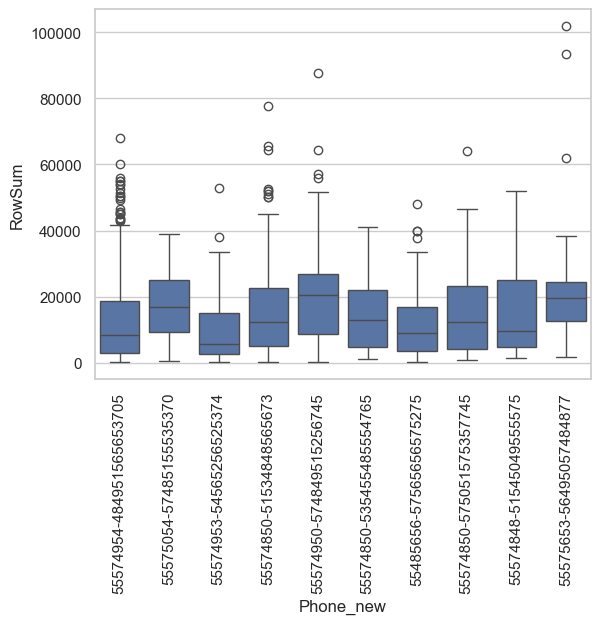

In [503]:
#Tоп-10 клиентов по количеству заказов:
top_clients = df['Phone_new'].value_counts().nlargest(10).index
df_top = df[df['Phone_new'].isin(top_clients)]

# Построение графика Box Whiskers
sns.boxplot(x='Phone_new', y='RowSum', data=df_top)
plt.xticks(rotation=90)
plt.show()

# Data mart for segmentation

In [504]:
df_clean = df_paid

In [505]:
df = df_clean
df = df.reset_index(drop=True)

In [506]:
df.head()

,Order_ID,Phone_new,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK
0,1303000520_TT,55575449-54535553535073,Онлайн-Резерв.,при получении,Центральный ф.о.,2420.0,1.0,0.0,2420.0,Аксессуары,Картриджи и бумага
1,1303000521_TT,55574954-53565052504871,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,8999.0,1.0,2000.0,8999.0,Крупная бытовая техника,Плиты
2,1303000523_TT,55575049-51505248534972,Онлайн-Резерв.,при получении,Центральный ф.о.,1790.0,1.0,0.0,1790.0,Цифровая Техника,Портативная электроника
3,1303000524_TT,55574954-53495654564877,Колл-центр,при получении,Северо-Западный ф.о.,1420.0,1.0,0.0,1420.0,Мелкая бытовая техника,Красота и здоровье
4,1303000525_TT,55575054-53544849485671,Онлайн-Резерв.,при получении,Центральный ф.о.,249.0,1.0,0.0,249.0,ТВ-Аудио,Музыкальные инструменты


In [507]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116888 entries, 0 to 116887
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Order_ID     116888 non-null  object 
 1   Phone_new    116888 non-null  object 
 2   Source       116888 non-null  object 
 3   PaymentType  116888 non-null  object 
 4   Region       116888 non-null  object 
 5   FullSum      116888 non-null  float64
 6   Quant        116888 non-null  float64
 7   RowDiscount  116888 non-null  float64
 8   RowSum       116888 non-null  float64
 9   TN           116888 non-null  object 
 10  TK           116888 non-null  object 
dtypes: float64(4), object(7)
memory usage: 9.8+ MB


In [508]:
#группировки по столбцам
group_Source = df.groupby(['Phone_new', 'Source']).sum()
group_PaymentType = df.groupby(['Phone_new', 'PaymentType']).sum()
group_Region = df.groupby(['Phone_new', 'Region']).sum()
group_TN = df.groupby(['Phone_new', 'TN']).sum()

In [509]:
#группировки по среднему значению и к-ву
group_Phone_mean = df.groupby('Phone_new')[df.select_dtypes(include='number').columns].mean()
group_Phone_count = df.groupby(['Phone_new']).count()

In [510]:
#создание датафрейма для записи информации по клиентам
data_clients = pd.DataFrame()
data_clients['id'] = df.drop_duplicates(subset = 'Phone_new')['Phone_new']
data_clients = data_clients.reset_index(drop=True)

In [511]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88354 entries, 0 to 88353
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      88354 non-null  object
dtypes: object(1)
memory usage: 690.4+ KB


*Add columns to separate categorical attributes.*

In [512]:
for i in df.TN.unique():
    data_clients[i] = i
    data_clients = data_clients.merge(group_TN['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'TN'], how = 'left')
    data_clients = data_clients.drop(columns = [i])
    data_clients = data_clients.rename(columns = {'Quant': i})
    data_clients = data_clients.fillna(0)

In [513]:
for i in df.Source.unique():
    data_clients[i] = i
    data_clients = data_clients.merge(group_Source['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'Source'], how = 'left')
    data_clients = data_clients.drop(columns = [i])
    data_clients = data_clients.rename(columns = {'Quant': i})
    data_clients = data_clients.fillna(0)

In [514]:
for i in df.PaymentType.unique():
    data_clients[i] = i
    data_clients = data_clients.merge(group_PaymentType['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'PaymentType'], how = 'left')
    data_clients = data_clients.drop(columns = [i])
    data_clients = data_clients.rename(columns = {'Quant': i})
    data_clients = data_clients.fillna(0)

In [515]:
for i in df.Region.unique():
    data_clients[i] = i
    data_clients = data_clients.merge(group_Region['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'Region'], how = 'left')
    data_clients = data_clients.drop(columns = [i])
    data_clients = data_clients.rename(columns = {'Quant': i})
    data_clients = data_clients.fillna(0)

In [516]:
#добавление основных столбцов с суммами и к-вом товаров
data_clients = data_clients.merge(df.groupby(['Phone_new']).sum(), left_on = ['id'], right_on = ['Phone_new'], how = 'left')

In [517]:
data_clients.head()

,id,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,Order_ID,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK
0,55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1303000520_TT,Онлайн-Резерв.,при получении,Центральный ф.о.,2420.0,1.0,0.0,2420.0,Аксессуары,Картриджи и бумага
1,55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1303000521_TT,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,8999.0,1.0,2000.0,8999.0,Крупная бытовая техника,Плиты
2,55575049-51505248534972,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1303000523_TT,Онлайн-Резерв.,при получении,Центральный ф.о.,1790.0,1.0,0.0,1790.0,Цифровая Техника,Портативная электроника
3,55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1303000524_TT,Колл-центр,при получении,Северо-Западный ф.о.,1420.0,1.0,0.0,1420.0,Мелкая бытовая техника,Красота и здоровье
4,55575054-53544849485671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1303000525_TT,Онлайн-Резерв.,при получении,Центральный ф.о.,249.0,1.0,0.0,249.0,ТВ-Аудио,Музыкальные инструменты


In [518]:
data_clients = data_clients.drop(columns=['FullSum', 'RowSum', 'Region', 'Order_ID', 'Source', 'PaymentType', 'TN',	'TK'])
data_clients.rename(columns = {'Quant' : 'КОЛ-ВО ВЫКУПЛ.ТОВ.'}, inplace = True) 
data_clients.rename(columns = {'RowDiscount' : 'СУММА СКИДКИ'}, inplace = True) 

In [519]:
#добавляем столбец с количеством чеков
data_clients = data_clients.merge(df.groupby(['Phone_new', 'Order_ID']).sum()['RowSum'].groupby('Phone_new').count(), left_on = ['id'], right_on = ['Phone_new'], how = 'left')

In [520]:
data_clients = data_clients.rename(columns={'RowSum':'КОЛ-ВО ЧЕКОВ'})

In [521]:
#среднее кол-во товаров в чеке
data_clients['СРЕД.КОЛ.ТОВ.вЧеке'] = data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.'] / data_clients['КОЛ-ВО ЧЕКОВ']

In [522]:
#добавляем столбец со средним чеком
data_clients = data_clients.merge(df.groupby(['Phone_new', 'Order_ID']).sum()['RowSum'].groupby('Phone_new').mean(), left_on = ['id'], right_on = ['Phone_new'], how = 'left')
data_clients = data_clients.rename(columns={'RowSum':'СРЕДНИЙ ЧЕК'})

In [523]:
#перезаполняем столбцы TN долями вместо кол-ва
data_clients['Аксессуары'] = data_clients['Аксессуары'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Крупная бытовая техника'] = data_clients['Крупная бытовая техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Цифровая Техника'] = data_clients['Цифровая Техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Мелкая бытовая техника'] = data_clients['Мелкая бытовая техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['ТВ-Аудио'] = data_clients['ТВ-Аудио'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Мебель'] = data_clients['Мебель'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Детские товары'] = data_clients['Детские товары'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Спорт и активный отдых'] = data_clients['Спорт и активный отдых'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Сделай сам'] = data_clients['Сделай сам'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Климат'] = data_clients['Климат'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Игры, софт и развлечения'] = data_clients['Игры, софт и развлечения'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Товары для дома'] = data_clients['Товары для дома'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Автотовары'] = data_clients['Автотовары'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']
data_clients['Элитная техника'] = data_clients['Элитная техника'] / data_clients['КОЛ-ВО ВЫКУПЛ.ТОВ.']

In [524]:
#витрина по клиентам
data_clients.head()

,id,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК
0,55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,2420.0
1,55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2000.0,1,1.0,8999.0
2,55575049-51505248534972,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1790.0
3,55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1420.0
4,55575054-53544849485671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,249.0


In [525]:
df1 = data_clients.copy()

In [526]:
df = df1

In [527]:
df.set_index('id', inplace = True)

In [528]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88354 entries, 0 to 88353
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        88354 non-null  object 
 1   Аксессуары                88354 non-null  float64
 2   Крупная бытовая техника   88354 non-null  float64
 3   Цифровая Техника          88354 non-null  float64
 4   Мелкая бытовая техника    88354 non-null  float64
 5   ТВ-Аудио                  88354 non-null  float64
 6   Мебель                    88354 non-null  float64
 7   Детские товары            88354 non-null  float64
 8   Спорт и активный отдых    88354 non-null  float64
 9   Сделай сам                88354 non-null  float64
 10  Климат                    88354 non-null  float64
 11  Игры, софт и развлечения  88354 non-null  float64
 12  Товары для дома           88354 non-null  float64
 13  Автотовары                88354 non-null  float64
 14  Элитна

# Correlation

In [529]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.context('seaborn');

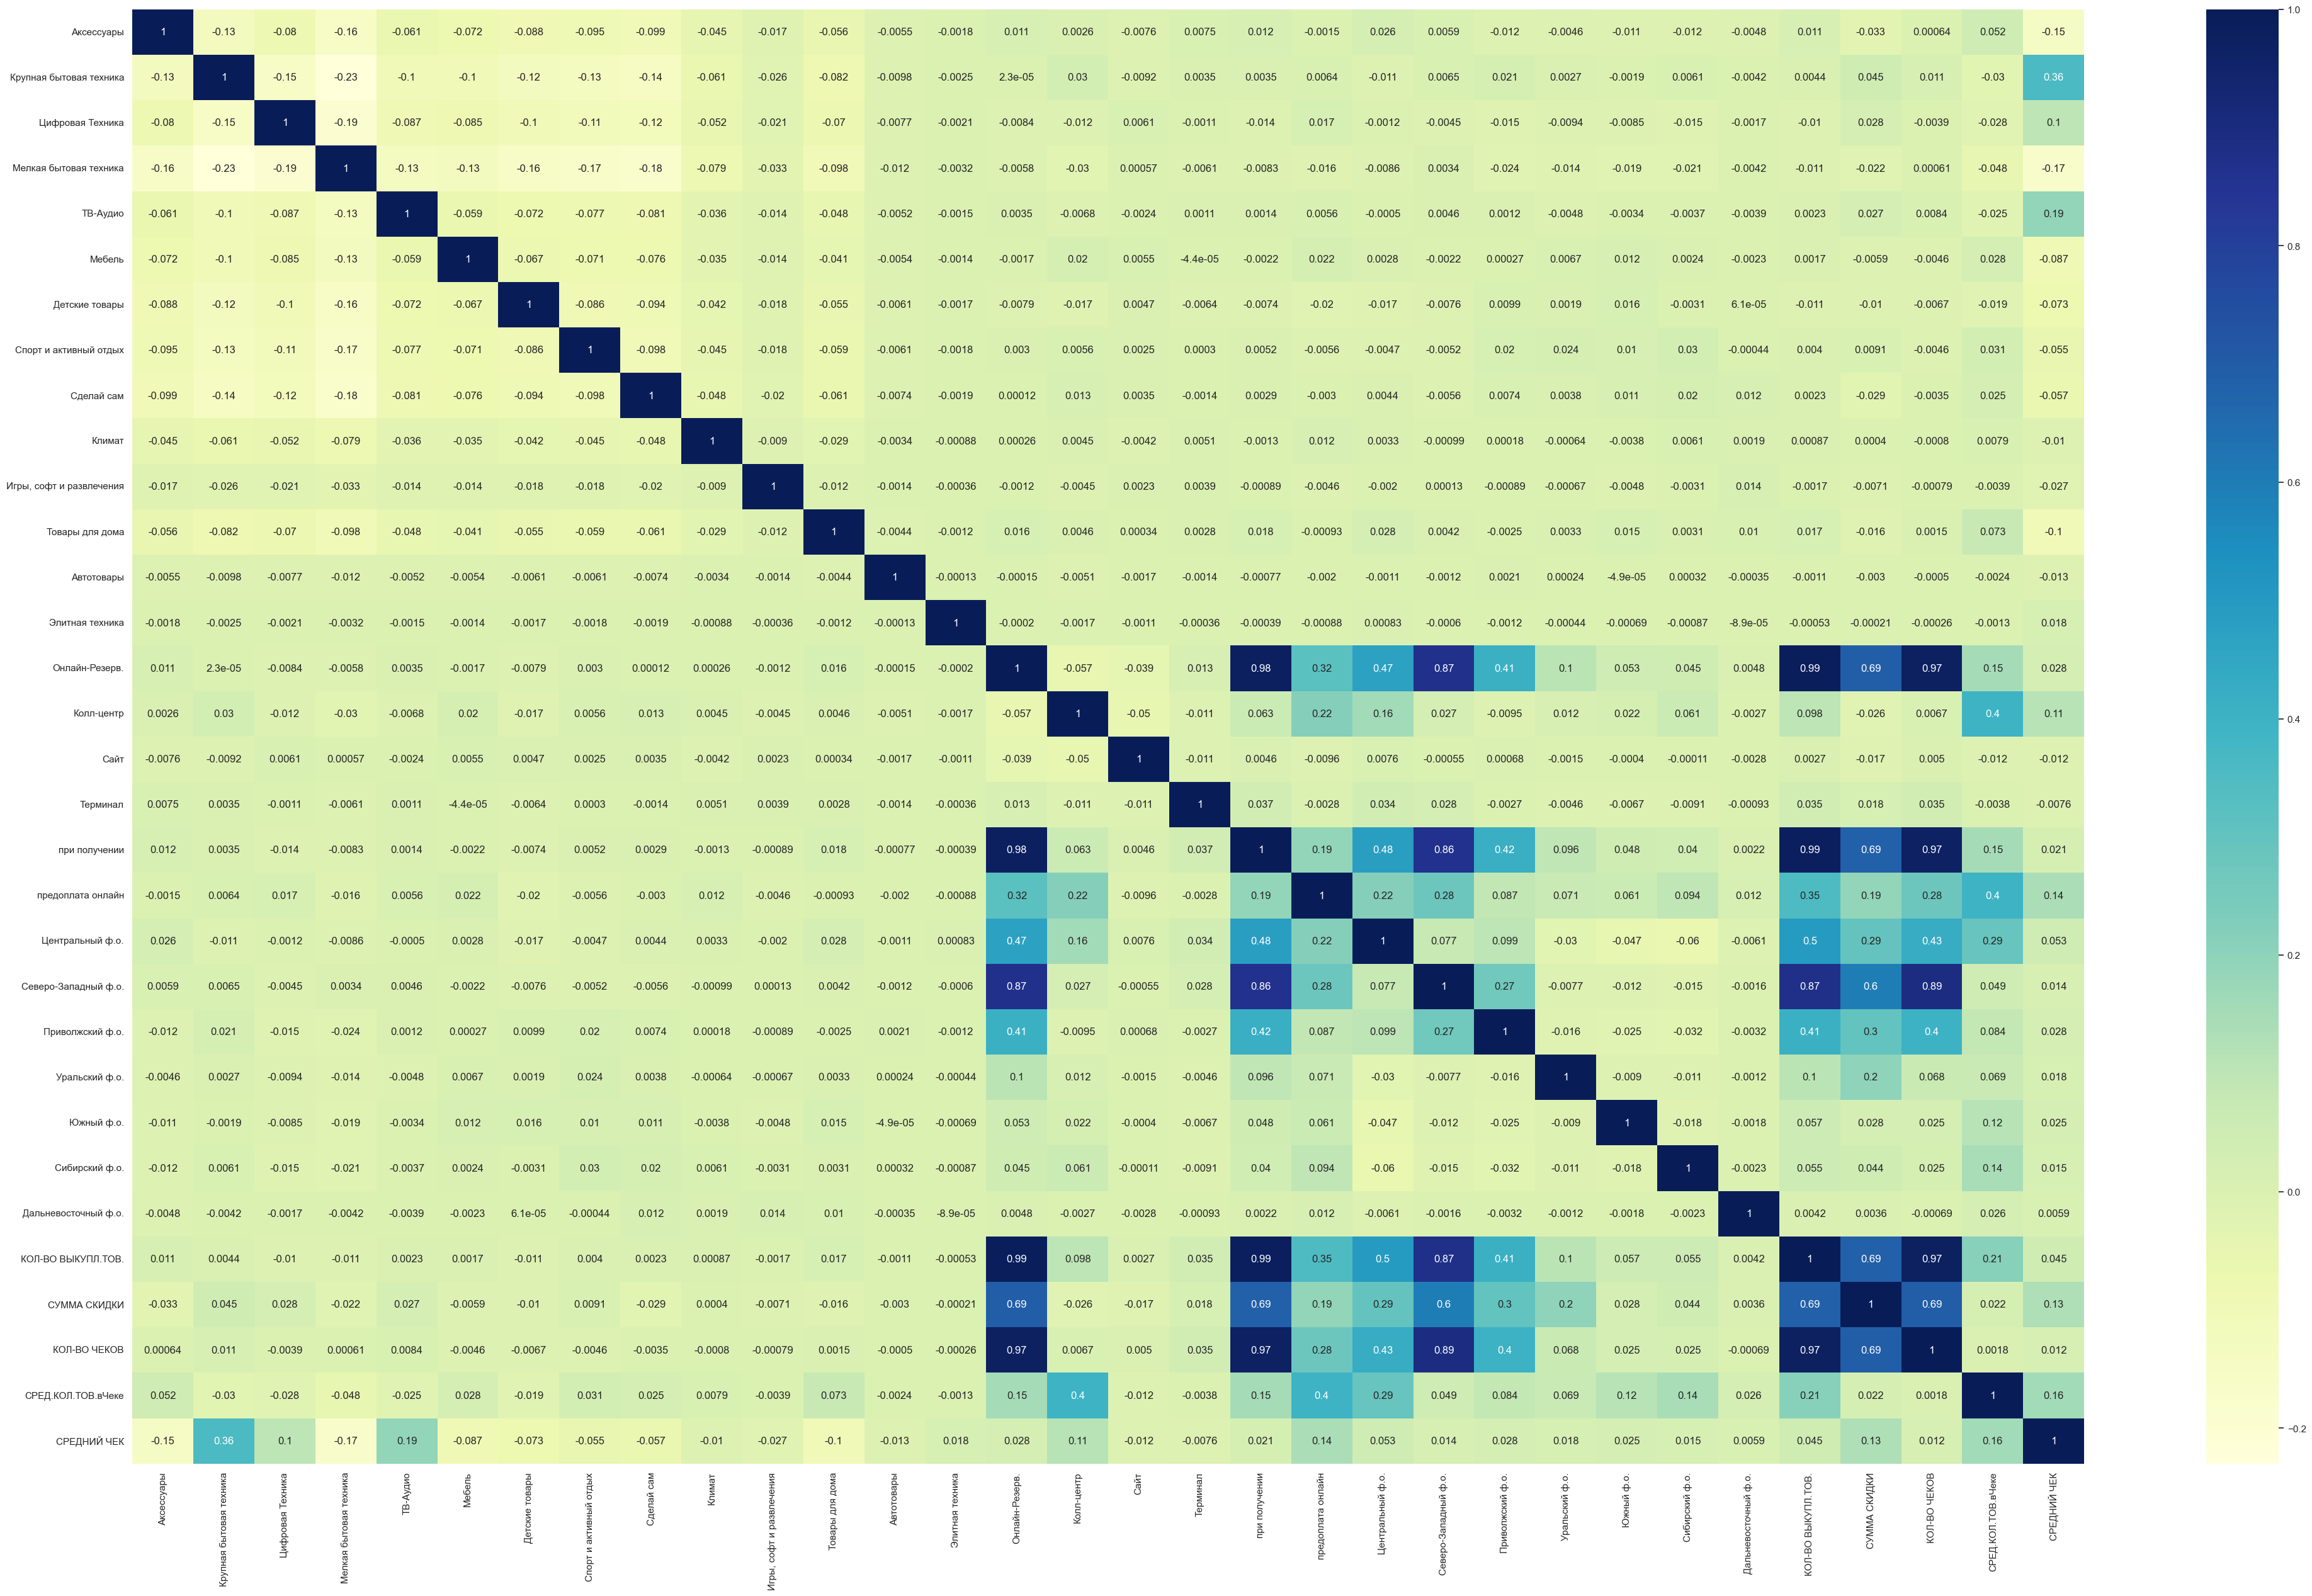

In [530]:
fig = plt.figure(figsize = (50, 30))
sns.heatmap(df.corr(), annot=True, cmap = 'YlGnBu');

In [531]:
corr = df.select_dtypes(include='number').corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК
Аксессуары,1.00,-0.11,-0.01,-0.14,-0.01,-0.07,-0.09,-0.09,-0.09,-0.03,-0.01,-0.03,-0.00,-0.00,0.12,-0.02,-0.01,0.01,0.15,-0.01,0.07,0.03,-0.03,-0.01,-0.03,-0.02,-0.01,0.18,-0.05,0.09,0.17,-0.22
Крупная бытовая техника,-0.11,1.00,-0.15,-0.21,-0.08,-0.10,-0.12,-0.13,-0.13,-0.04,-0.02,-0.06,-0.01,-0.00,-0.01,0.06,-0.01,0.00,0.02,0.03,-0.03,0.03,0.03,-0.01,-0.00,0.01,-0.01,0.04,0.02,0.08,-0.00,0.42
Цифровая Техника,-0.01,-0.15,1.00,-0.19,-0.07,-0.08,-0.10,-0.10,-0.11,-0.04,-0.02,-0.06,-0.01,-0.00,0.02,-0.01,0.01,0.00,-0.01,0.05,0.04,-0.00,-0.01,-0.02,-0.01,-0.01,-0.00,0.03,0.09,0.04,0.01,0.17
Мелкая бытовая техника,-0.14,-0.21,-0.19,1.00,-0.11,-0.12,-0.15,-0.16,-0.17,-0.07,-0.03,-0.07,-0.01,-0.00,0.02,-0.03,0.00,-0.01,0.00,-0.02,0.01,0.04,-0.03,-0.03,-0.02,-0.02,-0.00,-0.01,-0.04,0.03,-0.04,-0.16
ТВ-Аудио,-0.01,-0.08,-0.07,-0.11,1.00,-0.05,-0.07,-0.07,-0.07,-0.02,-0.01,-0.03,-0.00,-0.00,0.04,-0.00,-0.00,0.00,0.03,0.03,0.01,0.02,0.00,-0.01,-0.01,-0.01,-0.01,0.06,0.05,0.08,0.01,0.18
Мебель,-0.07,-0.10,-0.08,-0.12,-0.05,1.00,-0.06,-0.07,-0.07,-0.03,-0.01,-0.02,-0.01,-0.00,0.02,0.02,0.00,0.00,0.02,0.04,0.01,-0.01,-0.00,0.02,0.02,0.00,-0.00,0.06,0.06,0.03,0.06,-0.08
Детские товары,-0.09,-0.12,-0.10,-0.15,-0.07,-0.06,1.00,-0.08,-0.09,-0.04,-0.02,-0.05,-0.01,-0.00,0.01,-0.02,0.01,-0.01,0.02,-0.03,-0.01,-0.03,0.03,0.02,0.04,0.00,0.00,-0.00,0.01,0.02,-0.01,-0.04
Спорт и активный отдых,-0.09,-0.13,-0.10,-0.16,-0.07,-0.07,-0.08,1.00,-0.09,-0.04,-0.02,-0.05,-0.00,-0.00,0.04,0.00,0.00,0.00,0.06,-0.01,-0.01,-0.02,0.02,0.04,0.02,0.03,0.00,0.06,0.07,0.04,0.05,-0.05
Сделай сам,-0.09,-0.13,-0.11,-0.17,-0.07,-0.07,-0.09,-0.09,1.00,-0.04,-0.02,-0.04,-0.01,-0.00,0.04,0.01,0.00,0.00,0.06,-0.00,0.02,-0.03,0.00,0.01,0.01,0.02,0.01,0.07,-0.02,0.06,0.06,-0.01
Климат,-0.03,-0.04,-0.04,-0.07,-0.02,-0.03,-0.04,-0.04,-0.04,1.00,-0.01,-0.02,-0.00,-0.00,0.03,0.00,-0.01,0.00,0.03,0.01,0.02,0.00,0.00,0.00,-0.01,-0.01,0.00,0.05,0.02,0.04,0.04,0.02


In [532]:
#столбцы КОЛ-ВО ВЫКУПЛ.ТОВ.	и	СРЕД.КОЛ.ТОВ.вЧеке немного коррелированы (0,81), что и не удивительно
#оставляем среднее значение:	СРЕД.КОЛ.ТОВ.вЧеке
df = df.drop(['КОЛ-ВО ВЫКУПЛ.ТОВ.'], axis=1)

In [533]:
corr = df.select_dtypes(include='number').corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК
Аксессуары,1.00,-0.11,-0.01,-0.14,-0.01,-0.07,-0.09,-0.09,-0.09,-0.03,-0.01,-0.03,-0.00,-0.00,0.12,-0.02,-0.01,0.01,0.15,-0.01,0.07,0.03,-0.03,-0.01,-0.03,-0.02,-0.01,-0.05,0.09,0.17,-0.22
Крупная бытовая техника,-0.11,1.00,-0.15,-0.21,-0.08,-0.10,-0.12,-0.13,-0.13,-0.04,-0.02,-0.06,-0.01,-0.00,-0.01,0.06,-0.01,0.00,0.02,0.03,-0.03,0.03,0.03,-0.01,-0.00,0.01,-0.01,0.02,0.08,-0.00,0.42
Цифровая Техника,-0.01,-0.15,1.00,-0.19,-0.07,-0.08,-0.10,-0.10,-0.11,-0.04,-0.02,-0.06,-0.01,-0.00,0.02,-0.01,0.01,0.00,-0.01,0.05,0.04,-0.00,-0.01,-0.02,-0.01,-0.01,-0.00,0.09,0.04,0.01,0.17
Мелкая бытовая техника,-0.14,-0.21,-0.19,1.00,-0.11,-0.12,-0.15,-0.16,-0.17,-0.07,-0.03,-0.07,-0.01,-0.00,0.02,-0.03,0.00,-0.01,0.00,-0.02,0.01,0.04,-0.03,-0.03,-0.02,-0.02,-0.00,-0.04,0.03,-0.04,-0.16
ТВ-Аудио,-0.01,-0.08,-0.07,-0.11,1.00,-0.05,-0.07,-0.07,-0.07,-0.02,-0.01,-0.03,-0.00,-0.00,0.04,-0.00,-0.00,0.00,0.03,0.03,0.01,0.02,0.00,-0.01,-0.01,-0.01,-0.01,0.05,0.08,0.01,0.18
Мебель,-0.07,-0.10,-0.08,-0.12,-0.05,1.00,-0.06,-0.07,-0.07,-0.03,-0.01,-0.02,-0.01,-0.00,0.02,0.02,0.00,0.00,0.02,0.04,0.01,-0.01,-0.00,0.02,0.02,0.00,-0.00,0.06,0.03,0.06,-0.08
Детские товары,-0.09,-0.12,-0.10,-0.15,-0.07,-0.06,1.00,-0.08,-0.09,-0.04,-0.02,-0.05,-0.01,-0.00,0.01,-0.02,0.01,-0.01,0.02,-0.03,-0.01,-0.03,0.03,0.02,0.04,0.00,0.00,0.01,0.02,-0.01,-0.04
Спорт и активный отдых,-0.09,-0.13,-0.10,-0.16,-0.07,-0.07,-0.08,1.00,-0.09,-0.04,-0.02,-0.05,-0.00,-0.00,0.04,0.00,0.00,0.00,0.06,-0.01,-0.01,-0.02,0.02,0.04,0.02,0.03,0.00,0.07,0.04,0.05,-0.05
Сделай сам,-0.09,-0.13,-0.11,-0.17,-0.07,-0.07,-0.09,-0.09,1.00,-0.04,-0.02,-0.04,-0.01,-0.00,0.04,0.01,0.00,0.00,0.06,-0.00,0.02,-0.03,0.00,0.01,0.01,0.02,0.01,-0.02,0.06,0.06,-0.01
Климат,-0.03,-0.04,-0.04,-0.07,-0.02,-0.03,-0.04,-0.04,-0.04,1.00,-0.01,-0.02,-0.00,-0.00,0.03,0.00,-0.01,0.00,0.03,0.01,0.02,0.00,0.00,0.00,-0.01,-0.01,0.00,0.02,0.04,0.04,0.02


In [534]:
data_for_clusters = df

In [535]:
df1 = data_for_clusters.copy()

In [536]:
df1.head()

,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2420.0
55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,1,1.0,8999.0
55575049-51505248534972,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1790.0
55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1420.0
55575054-53544849485671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,249.0


# Remove outliers

In [537]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import numpy as np

In [538]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=0).fit_predict(df1.values)  # fit 3 trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df1.shape[0]))

% of outliers with Isolation forest: 0.019999094551463426
CPU times: user 138 ms, sys: 49.5 ms, total: 187 ms
Wall time: 243 ms


In [539]:
df1 = df1.loc[np.array(df1.index)[outliers == 1]]

In [540]:
df1.shape

(86587, 31)

In [541]:
df1.to_csv('data_for_clusters.csv')

# Нормализация

In [542]:
from sklearn import preprocessing
df_norm = df1.copy()

In [543]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(df_norm)

In [544]:
# После StandardScaler:
print("Среднее после стандартизации:", np.mean(X, axis=0))  # Должно быть ~ [0, 0, ..., 0]
print("Стандартное отклонение:", np.std(X, axis=0))         # Должно быть ~ [1, 1, ..., 1]

Среднее после стандартизации: [ 8.89542686e-17 -1.08320696e-17 -1.59198599e-17  7.02443302e-17
  3.75839991e-17  6.56489067e-19  9.71603819e-17 -9.16212554e-17
  4.00458331e-17  2.47824623e-17  2.92137635e-17  2.36336064e-17
 -2.05152833e-19 -4.59542347e-18  2.36336064e-17 -6.89313521e-17
 -7.87786881e-18  2.33053619e-17 -6.49924177e-17  1.36221481e-17
 -5.15343918e-17  1.87099384e-17 -4.66107238e-17 -3.54504096e-17
 -4.25897282e-17 -4.77595796e-17 -5.25191254e-18  1.83816939e-17
 -2.90168168e-16  2.74986858e-16 -1.89161170e-16]
Стандартное отклонение: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


In [545]:
df_norm = pd.DataFrame(X, columns=df1.columns, index=df1.index)

In [546]:
df_norm.to_csv('data_for_clusters_norm.csv')

# K-means

In [547]:
df = pd.read_csv('data_for_clusters.csv')
df.set_index('id', inplace = True)

In [405]:
from sklearn.cluster import KMeans #DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

### Метод локтя

In [549]:
%%time
# k means determine k
distortions = []
K = range(1,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=500, n_init=20, random_state=7).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    print('{} / {}'.format(k,K[-1]))

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
CPU times: user 1min 28s, sys: 50.7 s, total: 2min 19s
Wall time: 43.6 s


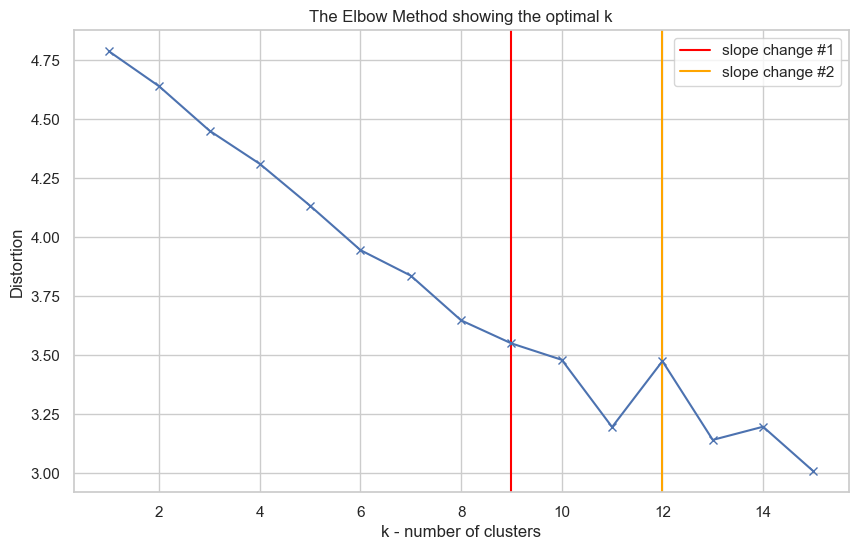

In [550]:
#определение оптимального к-ва кластеров методом локтя
plt.figure(figsize=(10, 6))
plt.axvline(9, 0, 1, label='slope change #1', color='red')
plt.axvline(12, 0, 1, label='slope change #2', color='orange')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend(); plt.show()

Перегибы: 4,7,9,12

самые оптимальные: 9 и 12 кластеров

### Дэвис-Боулдинг

In [551]:
results_db_kmeans = {}

for i in range(2, 16):
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X)
    db_index = davies_bouldin_score(X, labels)
    results_db_kmeans.update({i: db_index})

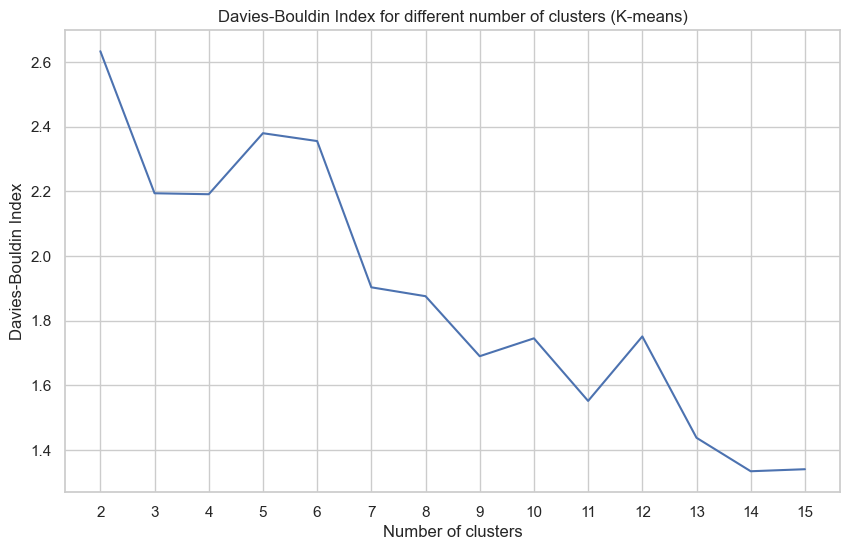

In [552]:
sns.set_theme(style="whitegrid")  # Установка стиля через seaborn

plt.figure(figsize=(10, 6))
plt.plot(list(results_db_kmeans.keys()), list(results_db_kmeans.values()))
plt.xticks(np.arange(2, 16, step=1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for different number of clusters (K-means)')
plt.show()

### Силуэт

results_sil_kmeans = {}
for i in range(2, 16):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X)
    
    sil_score = silhouette_score(X, labels)
    results_sil_kmeans.update({i: sil_score})

plt.figure(figsize=(10, 6))

plt.plot(list(results_sil_kmeans.keys()), list(results_sil_kmeans.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (K-means)')
plt.show()

### Калински-Харабаш

In [553]:
results_ch_kmeans = {}
for i in range(2, 16):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X)
    
    ch_score = calinski_harabasz_score(X, labels)
    results_ch_kmeans.update({i: ch_score})

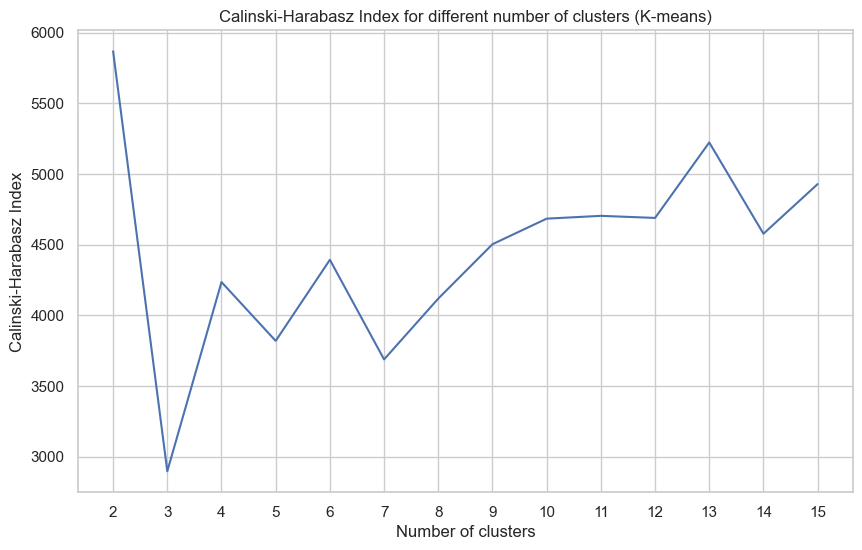

In [554]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_kmeans.keys()), list(results_ch_kmeans.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (K-means)')
plt.show()

**Вывод:** По итогам применения 3 методов нахождения оптимального количества кластеров, оказалось, что наиболее оптимальными являются 9, 11, 12,13 кластеров

### K-means for 9 clusters

In [555]:
from sklearn.decomposition import PCA, TruncatedSVD

Y_pca = PCA(n_components=3).fit_transform(X);
Y_svd = TruncatedSVD(n_components=3).fit_transform(X);
K = 9
kmeanModel = KMeans(n_clusters=K).fit(X)

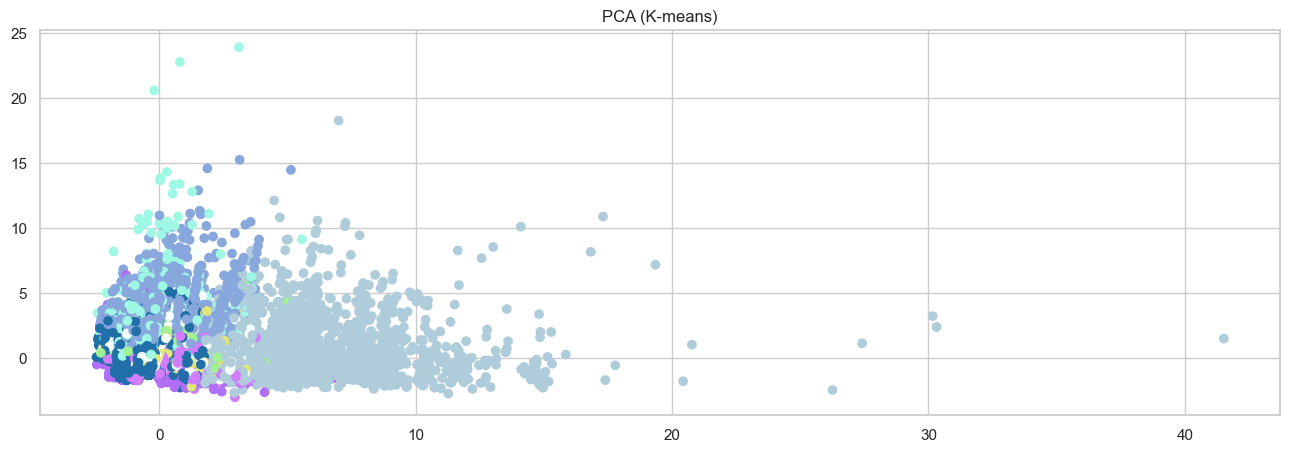

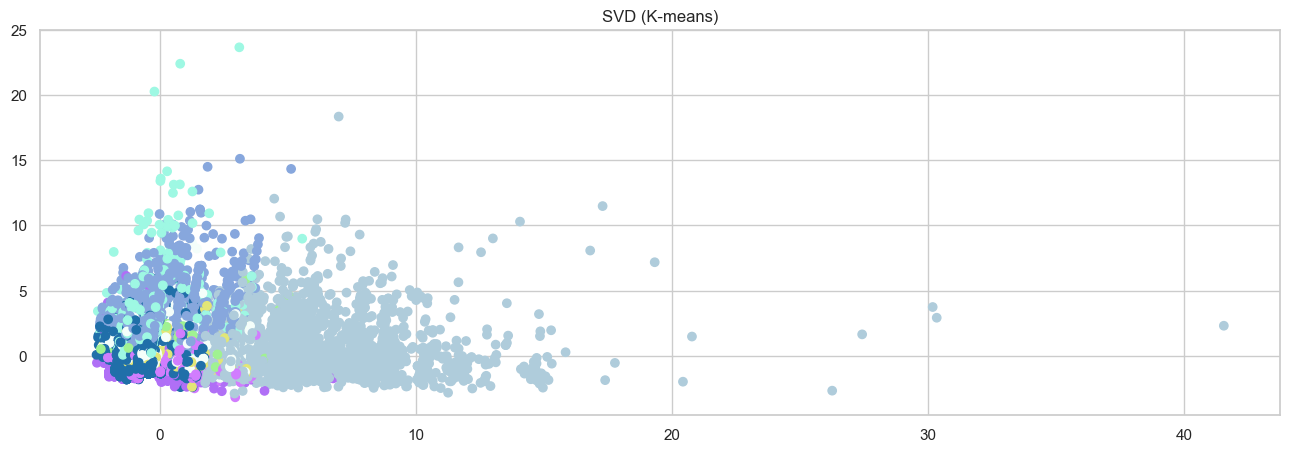

In [556]:
np.random.seed(21)
colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmeanModel.labels_))))

plt.figure(figsize=(16,5));
plt.title('PCA (K-means)')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

plt.figure(figsize=(16,5)); plt.title('SVD (K-means)')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c=c_arr);

In [557]:
# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 

# cluster label for each data point
labels = kmeanModel.labels_

df['Labels'] = kmeanModel.labels_

df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('df: ', len(df))

Segment 1:  7329
Segment 2:  34955
Segment 3:  8227
Segment 4:  4392
Segment 5:  12142
Segment 6:  5862
Segment 7:  6550
Segment 8:  3092
Segment 9:  4038
df:  86587


In [558]:
#print(f'Silhouette Score(n=9): {silhouette_score(X, labels)}')
print(f'Davies-Boulding Index (n=9): {davies_bouldin_score(X, labels)}')
print(f'Calinski-Harabasz Index (n=9): {calinski_harabasz_score(X, labels)}')

Davies-Boulding Index (n=9): 1.7694144565310954
Calinski-Harabasz Index (n=9): 4362.493930068004


### K-means for 11 clusters

In [559]:
K = 11
#kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)
kmeanModel = KMeans(n_clusters=K).fit(X)

# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 

# cluster label for each data point
labels = kmeanModel.labels_

df['Labels'] = kmeanModel.labels_

df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('Segment 10: ', len(df_10))
print('Segment 11: ', len(df_11))
print('df: ', len(df))

Segment 1:  12076
Segment 2:  32410
Segment 3:  8513
Segment 4:  3
Segment 5:  7333
Segment 6:  4391
Segment 7:  3094
Segment 8:  4033
Segment 9:  5817
Segment 10:  8628
Segment 11:  289
df:  86587


In [560]:
df.groupby('Labels').sum().to_excel('11_clusters.xlsx')

### K-means for 12 clusters

In [561]:
K = 12
#kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)
kmeanModel = KMeans(n_clusters=K).fit(X)
# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 
# cluster label for each data point
labels = kmeanModel.labels_
df['Labels'] = kmeanModel.labels_
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]
df_12 = df[(df['Labels'] == 11)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('Segment 10: ', len(df_10))
print('Segment 11: ', len(df_11))
print('Segment 12: ', len(df_12))
print('df: ', len(df))

Segment 1:  18487
Segment 2:  11855
Segment 3:  12763
Segment 4:  10863
Segment 5:  6871
Segment 6:  7637
Segment 7:  6345
Segment 8:  4285
Segment 9:  3
Segment 10:  47
Segment 11:  4525
Segment 12:  2906
df:  86587


In [562]:
#сводная таблица по всем клиентам с номерами кластеров в соответствии с сегментацией

In [563]:
df.to_excel('labels_for_12_clusters.xlsx')

In [564]:
#сводная таблица данных по всем кластерам
df.groupby('Labels').sum().to_excel('12_clusters.xlsx')

In [565]:
df.head()

,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,Labels
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2420.0,1
55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,1,1.0,8999.0,2
55575049-51505248534972,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1790.0,3
55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1420.0,0
55575054-53544849485671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,249.0,10


### K-means for 13 clusters

In [143]:
K = 13
#kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)
kmeanModel = KMeans(n_clusters=K).fit(X)

# coordinates of cluster center
centroids = kmeanModel.cluster_centers_ 

# cluster label for each data point
labels = kmeanModel.labels_

df['Labels'] = kmeanModel.labels_

df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]
df_12 = df[(df['Labels'] == 11)]
df_13 = df[(df['Labels'] == 12)]

print('Segment 1: ', len(df_1))
print('Segment 2: ', len(df_2))
print('Segment 3: ', len(df_3))
print('Segment 4: ', len(df_4))
print('Segment 5: ', len(df_5))
print('Segment 6: ', len(df_6))
print('Segment 7: ', len(df_7))
print('Segment 8: ', len(df_8))
print('Segment 9: ', len(df_9))
print('Segment 10: ', len(df_10))
print('Segment 11: ', len(df_11))
print('Segment 12: ', len(df_12))
print('Segment 13: ', len(df_13))
print('df: ', len(df))

Segment 1:  999
Segment 2:  22894
Segment 3:  4588
Segment 4:  6557
Segment 5:  7265
Segment 6:  2657
Segment 7:  11887
Segment 8:  8647
Segment 9:  6314
Segment 10:  1475
Segment 11:  4109
Segment 12:  4487
Segment 13:  4708
df:  86587


In [144]:
df.groupby('Labels').sum().to_excel('13_clusters.xlsx')

# Expectation-Maximization Algorithm

In [145]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics

### Дэвис Боулдинг

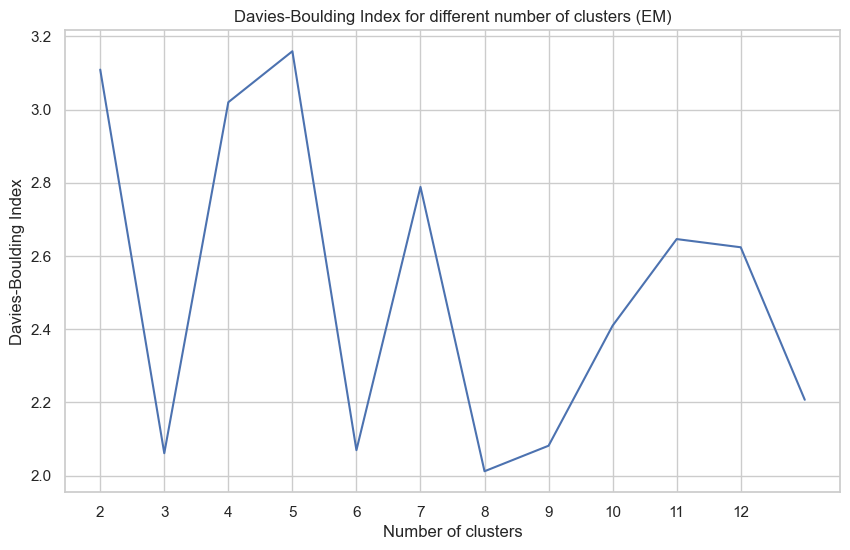

In [146]:
results_ch_em = {}
for i in range(2, 14):
    
    gm = GaussianMixture(n_components = i)
    labels = gm.fit_predict(X)
    
    ch_score = metrics.davies_bouldin_score(X, labels)
    results_ch_em.update({i: ch_score})

plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_em.keys()), list(results_ch_em.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 13, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Boulding Index')
plt.title('Davies-Boulding Index for different number of clusters (EM)')
plt.show()

### Калински-Харабаш

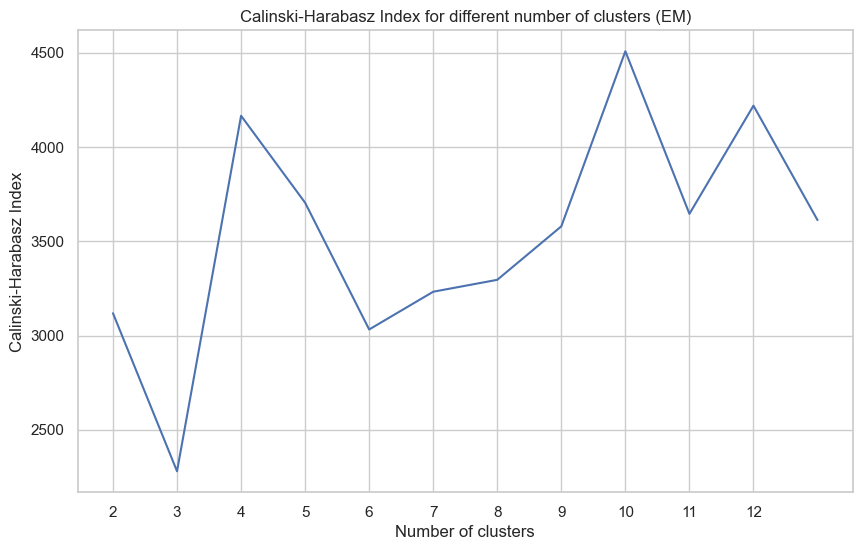

In [147]:
results_ch_em = {}
for i in range(2, 14):
    
    gm = GaussianMixture(n_components = i)
    labels = gm.fit_predict(X)
    
    ch_score = metrics.calinski_harabasz_score(X, labels)
    results_ch_em.update({i: ch_score})

plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_em.keys()), list(results_ch_em.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 13, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (EM)')
plt.show()

Наилучшие значения индекса наблюдаются при 10, 12 кластерах (высокие и стабильные значения, особенно при 10).

### EM for 10 clusters

In [148]:
df = df_norm

In [149]:
from sklearn import preprocessing
import pandas as pd

In [150]:
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df.iloc[:,1:])

In [151]:
import scipy
scipy.stats.normaltest(X)

NormaltestResult(statistic=array([ 27581.52999353,  40500.96795908,  15169.90753172,  66061.02117974,
        69185.20829248,  54475.91482048,  50980.23627584,  46503.29539376,
       102286.06967044, 176254.22785628,  85222.96820728, 260694.14254493,
       403776.05340879,  42203.42270272,  57762.64339386,  95028.29357176,
       178145.4011117 ,  55149.3030565 , 106701.36960888,  30923.86070611,
        50594.29464212,  97623.94214025, 127206.44521994, 103387.93793034,
        92988.6651599 , 342068.47741754, 155701.51561572,  85552.87299314,
        95630.29986028,  91929.90298788]), pvalue=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [152]:
Y_pca = PCA(n_components=3).fit_transform(X);
Y_svd = TruncatedSVD(n_components=3).fit_transform(X);

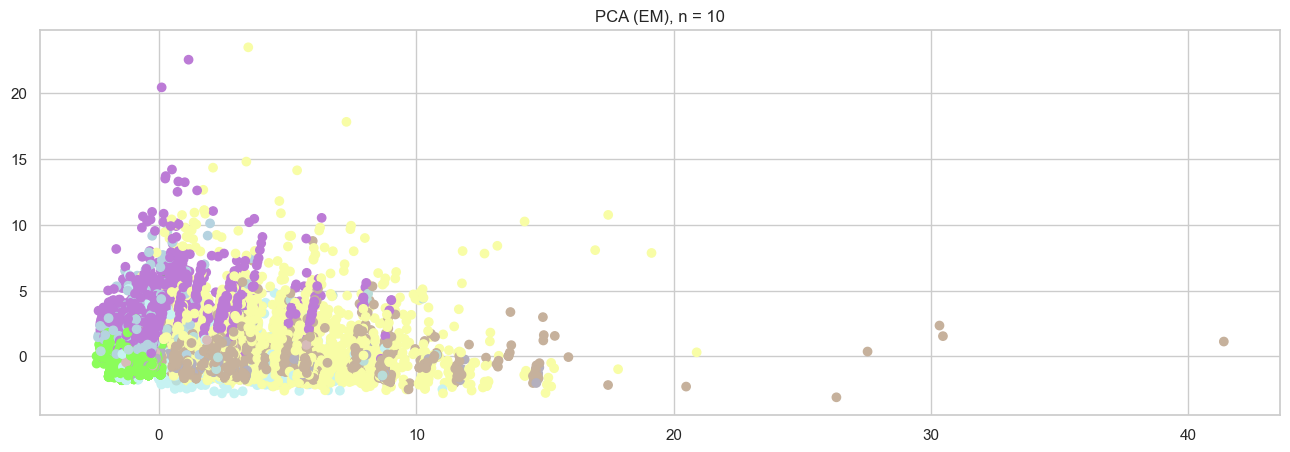

In [153]:
n = 10
gm = GaussianMixture(n_components=n)
labels = gm.fit_predict(X)
df_labels = pd.DataFrame()
df_labels['Labels'] = labels

colors = np.sqrt(np.random.randint(0,255, size=(len(set(labels)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(16,5)); plt.title('PCA (EM), n = 10')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

In [154]:
df = df_labels

In [155]:
df_labels.shape

(86587, 1)

In [156]:
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
data_sel10={0: df_1, 1: df_2, 2: df_3, 3: df_4, 4: df_5, 5: df_6, 6: df_7, 7: df_8, 8: df_9, 9: df_10}

In [157]:
for i in data_sel10.values():
  print(len(i))

36543
8694
930
16379
4760
1701
5615
3
7728
4234


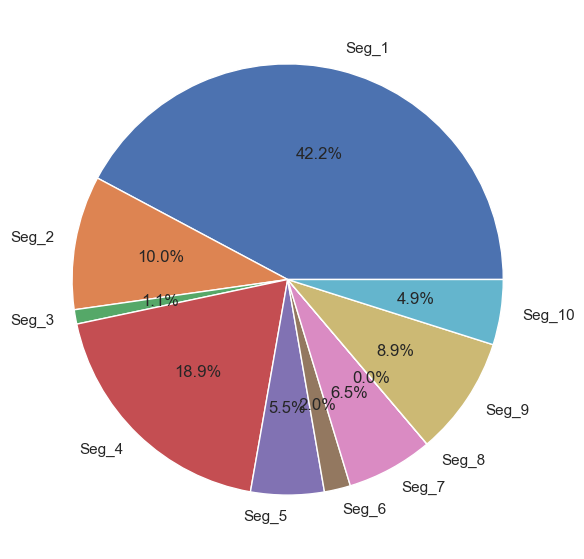

In [158]:
fig = plt.figure(figsize =(10, 7))
data = [len(i) for i in data_sel10.values()]
labels = [('Seg_' + str(i)) for i in range(1, 11)]
plt.pie(data, labels=labels, autopct='%1.1f%%')

plt.show()

In [159]:
df['Labels'] = df_labels['Labels']

In [160]:
#сводная таблица по всем клиентам с номерами кластеров в соответствии с сегментацией
df.to_excel('labels_for_10_clusters.xlsx')

In [161]:
df2 = pd.read_excel('labels_for_10_clusters.xlsx', index_col=0) # таблица с кластерами

In [162]:
df_ind = df2

### EM для 12 кластеров

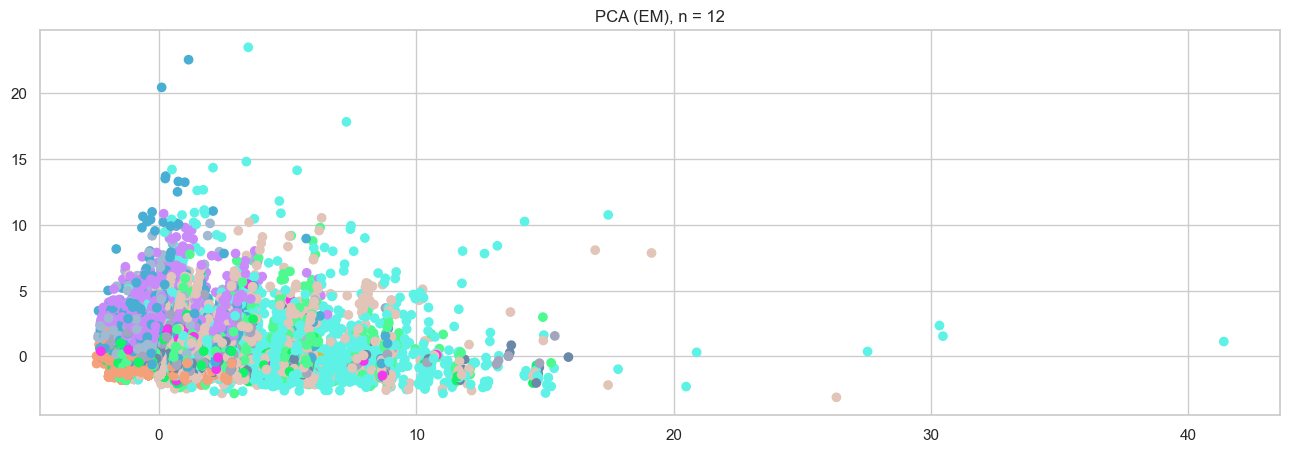

In [163]:
n = 12
gm = GaussianMixture(n_components=n)
labels = gm.fit_predict(X)
df_labels = pd.DataFrame()
df_labels['Labels'] = labels

colors = np.sqrt(np.random.randint(0,255, size=(len(set(labels)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(16,5)); plt.title('PCA (EM), n = 12')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

In [164]:
df = df_labels
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]
df_12 = df[(df['Labels'] == 11)]

data_sel12={0: df_1, 1: df_2, 2: df_3, 3: df_4, 4: df_5, 5: df_6, 6: df_7, 7: df_8, 8: df_9, 9: df_10, 10: df_11, 11: df_12}

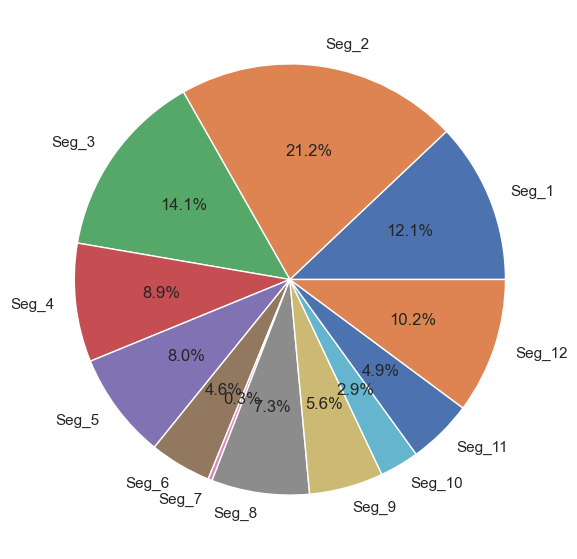

In [165]:
fig = plt.figure(figsize =(10, 7))
data = [len(i) for i in data_sel12.values()]
labels = [('Seg_' + str(i)) for i in range(1, 13)]
plt.pie(data, labels=labels, autopct='%1.1f%%')

plt.show()

### EM для 13 кластеров

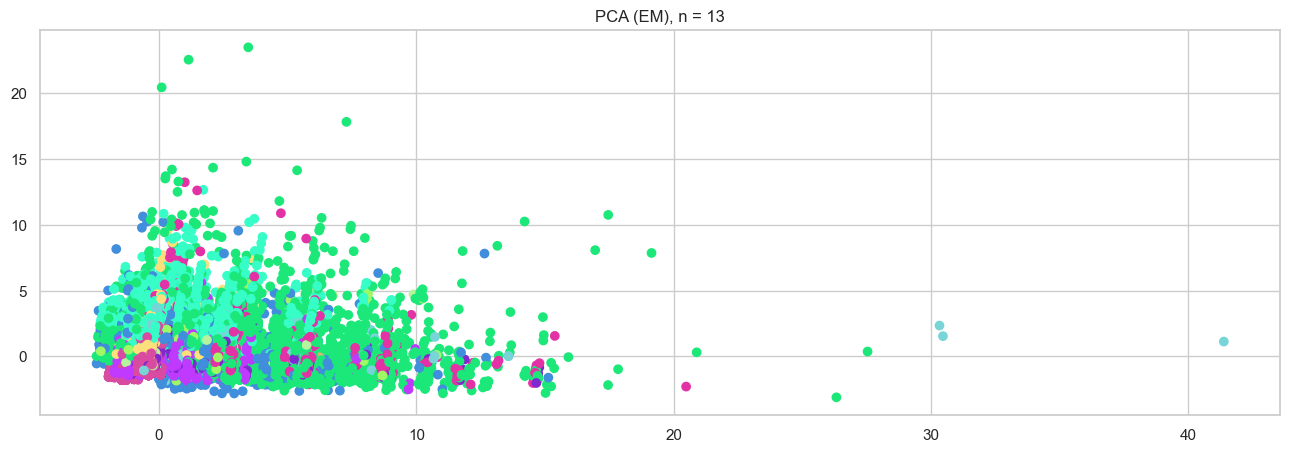

In [166]:
n = 13
gm = GaussianMixture(n_components=n)
labels = gm.fit_predict(X)
df_labels = pd.DataFrame()
df_labels['Labels'] = labels

colors = np.sqrt(np.random.randint(0,255, size=(len(set(labels)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(16,5)); plt.title('PCA (EM), n = 13')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

In [167]:
df = df_labels
df_1 = df[(df['Labels'] == 0)]
df_2 = df[(df['Labels'] == 1)]
df_3 = df[(df['Labels'] == 2)]
df_4 = df[(df['Labels'] == 3)]
df_5 = df[(df['Labels'] == 4)]
df_6 = df[(df['Labels'] == 5)]
df_7 = df[(df['Labels'] == 6)]
df_8 = df[(df['Labels'] == 7)]
df_9 = df[(df['Labels'] == 8)]
df_10 = df[(df['Labels'] == 9)]
df_11 = df[(df['Labels'] == 10)]
df_12 = df[(df['Labels'] == 11)]
df_13 = df[(df['Labels'] == 12)]

data_sel13={0: df_1, 1: df_2, 2: df_3, 3: df_4, 4: df_5, 5: df_6, 6: df_7, 7: df_8, 8: df_9, 9: df_10, 10: df_11, 11: df_12, 12: df_13}

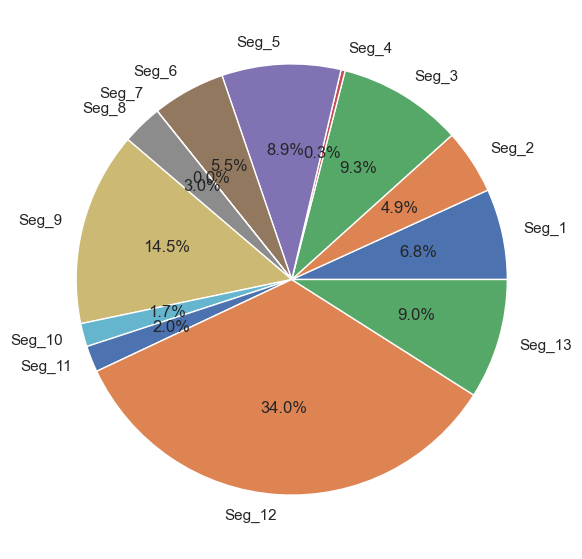

In [168]:
fig = plt.figure(figsize =(10, 7))
data = [len(i) for i in data_sel13.values()]
labels = [('Seg_' + str(i)) for i in range(1, 14)]
plt.pie(data, labels=labels, autopct='%1.1f%%')

plt.show()

# RFM

In [647]:
df = data_clients.copy()

In [648]:
df.reset_index(inplace=True)

In [649]:
from datetime import datetime

In [650]:
df3 = df_original.copy()
df_original['OrderDate'] = pd.to_datetime(df_original['OrderDate'])
df3.rename(columns={'Phone_new': 'id'}, inplace=True)

In [651]:
# Объединение данных по id
df_merged = df.merge(
    df3[['id', 'OrderDate']],  # выбираем только нужные колонки из df_original
    on='id',                           # ключ для объединения
    how='left'                         # сохраняем все строки из df_norm
)

In [652]:
print(df_merged[['id', 'OrderDate']].head())

                        id  OrderDate
0  55575449-54535553535073 2016-03-01
1  55575449-54535553535073 2016-03-01
2  55574954-53565052504871 2016-03-01
3  55574954-53565052504871 2016-03-01
4  55575049-51505248534972 2016-03-01


In [653]:
df_rfm = df.copy()

# Текущая дата
current_date = datetime.now()

# Расчет Recency (дней с последней транзакции)
df_rfm['Recency'] = (current_date - df_merged['OrderDate']).dt.days
df_rfm['Frequency'] = df['КОЛ-ВО ВЫКУПЛ.ТОВ.']
df_rfm['Monetary'] = df['СРЕДНИЙ ЧЕК']

In [654]:
df_rfm

,index,id,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,Recency,Frequency,Monetary
0,0,55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,2420.0,3337,1.0,2420.0
1,1,55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2000.0,1,1.0,8999.0,3337,1.0,8999.0
2,2,55575049-51505248534972,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1790.0,3337,1.0,1790.0
3,3,55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1420.0,3337,1.0,1420.0
4,4,55575054-53544849485671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,249.0,3337,1.0,249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88349,88349,55575054-49505554565675,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1390.0,3299,1.0,1390.0
88350,88350,55575055-51565055494871,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,19990.0,3299,1.0,19990.0
88351,88351,55575053-55485548545470,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,500.0,1,1.0,11370.0,3299,1.0,11370.0
88352,88352,55574957-51495048515075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,899.0,3299,1.0,899.0


In [655]:
# R - чем меньше, тем лучше => используем `qcut` с меткой 5 = самые "свежие"
df_rfm['R_score'] = pd.qcut(df_rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
# F и M — чем больше, тем лучше
df_rfm['F_score'] = pd.qcut(df_rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df_rfm['M_score'] = pd.qcut(df_rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

In [656]:
# Объединённый RFM код
df_rfm['RFM_score'] = (
    df_rfm['R_score'].astype(str) +
    df_rfm['F_score'].astype(str) +
    df_rfm['M_score'].astype(str)
)

# Общая сумма баллов
df_rfm['RFM_total'] = df_rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)

# Сегментация
def rfm_segment(x):
    if x >= 13:
        return 'Champions'
    elif x >= 10:
        return 'Loyal Customers'
    elif x >= 7:
        return 'Potential Loyalist'
    elif x >= 4:
        return 'Needs Attention'
    else:
        return 'At Risk'

df_rfm['segment'] = df_rfm['RFM_total'].apply(rfm_segment)

In [657]:
df_rfm

,index,id,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_total,segment
0,0,55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,2420.0,3337,1.0,2420.0,1,1,2,112,4,Needs Attention
1,1,55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2000.0,1,1.0,8999.0,3337,1.0,8999.0,1,1,4,114,6,Needs Attention
2,2,55575049-51505248534972,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1790.0,3337,1.0,1790.0,1,1,1,111,3,At Risk
3,3,55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1420.0,3337,1.0,1420.0,1,1,1,111,3,At Risk
4,4,55575054-53544849485671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,249.0,3337,1.0,249.0,1,1,1,111,3,At Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88349,88349,55575054-49505554565675,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1390.0,3299,1.0,1390.0,5,5,1,551,11,Loyal Customers
88350,88350,55575055-51565055494871,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,19990.0,3299,1.0,19990.0,5,5,5,555,15,Champions
88351,88351,55575053-55485548545470,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,500.0,1,1.0,11370.0,3299,1.0,11370.0,5,5,4,554,14,Champions
88352,88352,55574957-51495048515075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,899.0,3299,1.0,899.0,5,5,1,551,11,Loyal Customers


In [179]:
rfm_clear = df_rfm[['id', 'Recency', 'Frequency', 'Monetary',
                    'R_score', 'F_score', 'M_score', 'segment']].copy()
rfm_clear['RFM_score'] = (
    rfm_clear['R_score'].astype(str) +
    rfm_clear['F_score'].astype(str) +
    rfm_clear['M_score'].astype(str)
)

In [180]:
rfm_clear

,id,Recency,Frequency,Monetary,R_score,F_score,M_score,segment,RFM_score
0,55575449-54535553535073,3337,1.0,2420.0,1,1,2,Needs Attention,112
1,55574954-53565052504871,3337,1.0,8999.0,1,1,4,Needs Attention,114
2,55575049-51505248534972,3337,1.0,1790.0,1,1,1,At Risk,111
3,55574954-53495654564877,3337,1.0,1420.0,1,1,1,At Risk,111
4,55575054-53544849485671,3337,1.0,249.0,1,1,1,At Risk,111
...,...,...,...,...,...,...,...,...,...
88349,55575054-49505554565675,3299,1.0,1390.0,5,5,1,Loyal Customers,551
88350,55575055-51565055494871,3299,1.0,19990.0,5,5,5,Champions,555
88351,55575053-55485548545470,3299,1.0,11370.0,5,5,4,Champions,554
88352,55574957-51495048515075,3299,1.0,899.0,5,5,1,Loyal Customers,551


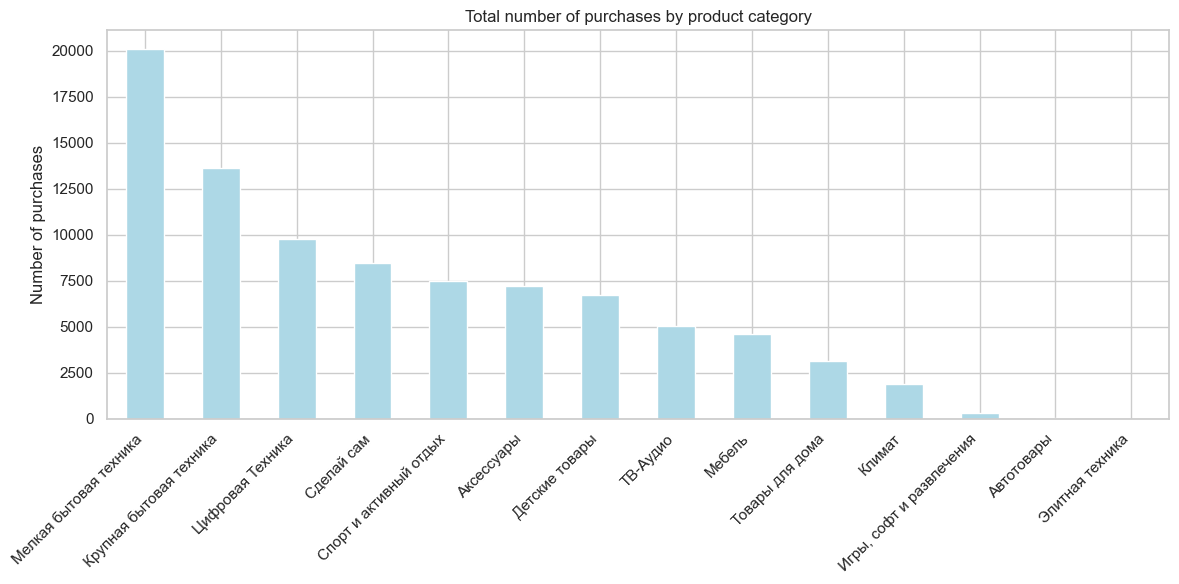

In [662]:
product_columns = [
    'Аксессуары', 'Крупная бытовая техника', 'Цифровая Техника', 'Мелкая бытовая техника',
    'ТВ-Аудио', 'Мебель', 'Детские товары', 'Спорт и активный отдых', 'Сделай сам',
    'Климат', 'Игры, софт и развлечения', 'Товары для дома', 'Автотовары', 'Элитная техника'
]

# Посчитаем общее количество покупок по каждой категории
category_totals = df_rfm[product_columns].sum().sort_values(ascending=False)

# Построим график
plt.figure(figsize=(12, 6))
category_totals.plot(kind='bar', color='lightblue')
plt.title('Total number of purchases by product category')
plt.ylabel('Number of purchases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Text(47.24999999999999, 0.5, 'Segment')

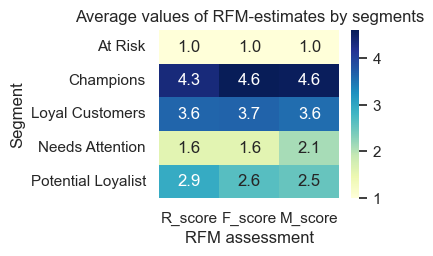

In [658]:
plt.subplot(2, 2, 3)
rfm_means = df_rfm.groupby('segment')[['R_score', 'F_score', 'M_score']].mean()
sns.heatmap(rfm_means, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Average values of RFM-estimates by segments')
plt.xlabel('RFM assessment')
plt.ylabel('Segment')

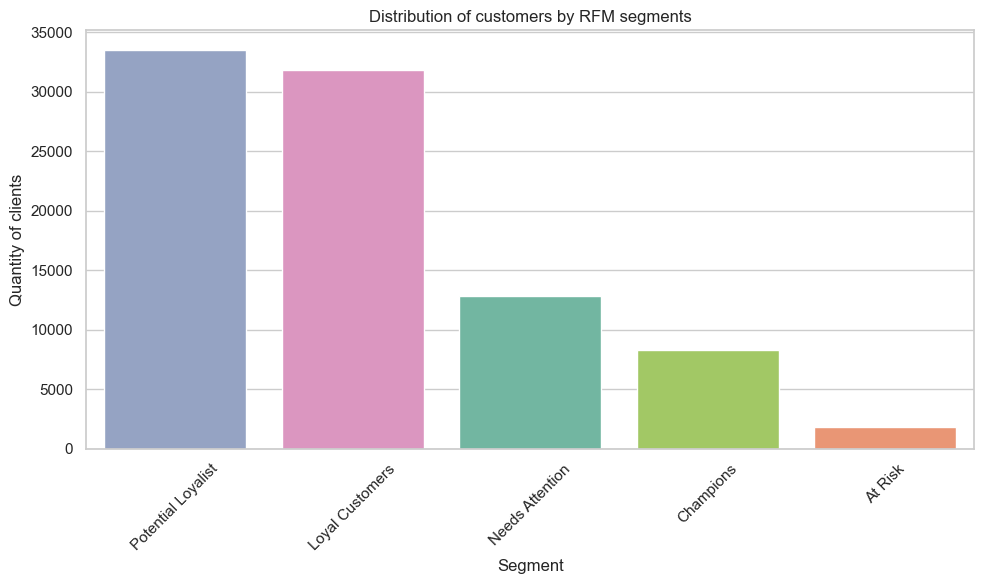

In [181]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm_clear, x='segment', hue='segment', order=rfm_clear['segment'].value_counts().index, palette='Set2', legend=False)

plt.title('Distribution of customers by RFM segments')
plt.xlabel('Segment')
plt.ylabel('Quantity of clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

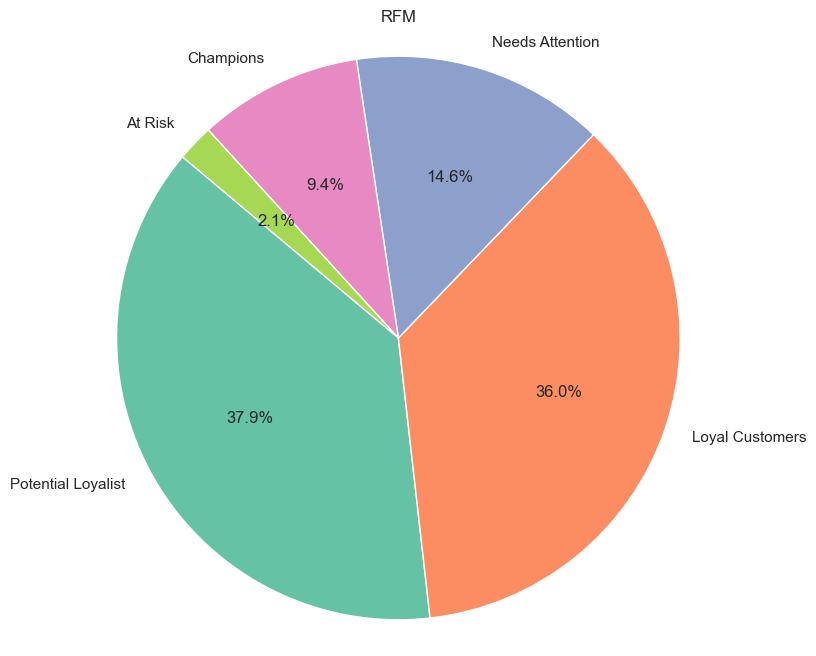

In [182]:
segment_counts = rfm_clear['segment'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('RFM')
plt.axis('equal')
plt.show()

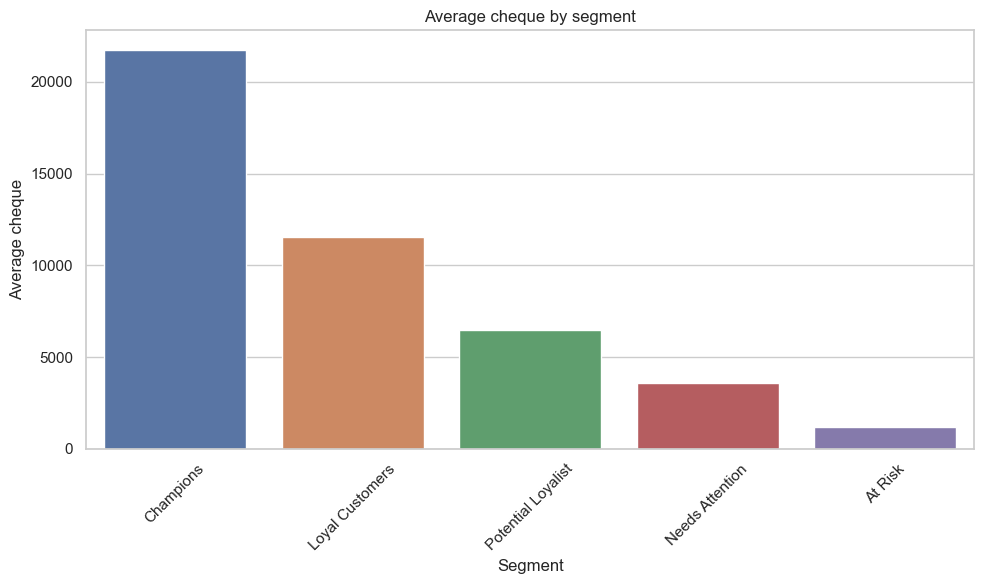

In [183]:
# Average monetary for each segment
avg_monetary_by_segment = rfm_clear.groupby('segment')['Monetary'].mean().sort_values(ascending=False)

# Graph
plt.figure(figsize=(10,6))
sns.barplot(x=avg_monetary_by_segment.index, y=avg_monetary_by_segment.values, hue=avg_monetary_by_segment.index, legend=False)

plt.title('Average cheque by segment')
plt.xlabel('Segment')
plt.ylabel('Average cheque')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Hierarchical clustering

In [184]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

### Использование предвыборки (n = 3000)

In [185]:
sample = df_norm.sample(n=3000, random_state=42)
X = sample.values

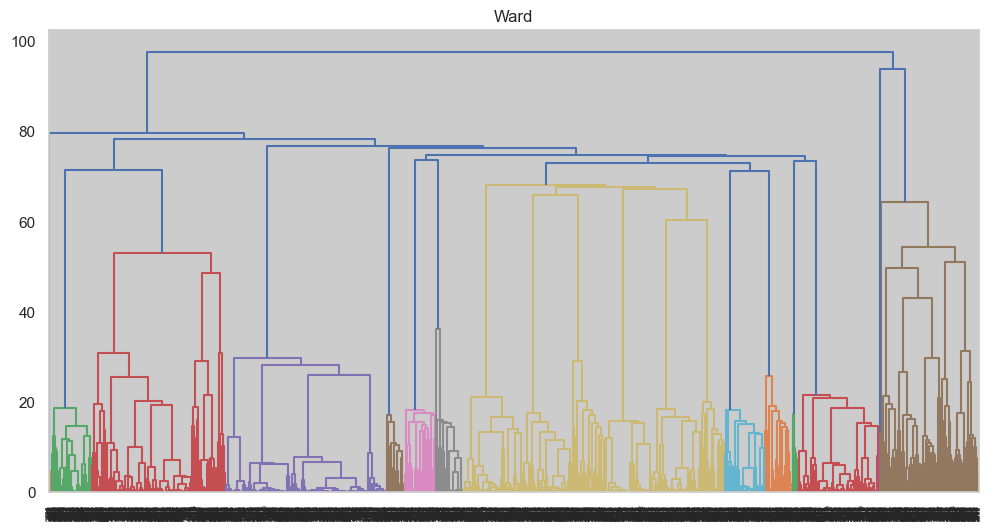

In [186]:
Y = linkage(X, method='ward')
plt.figure(figsize=(12, 6))
plt.title("Ward")
dendrogram(Y)
plt.show()

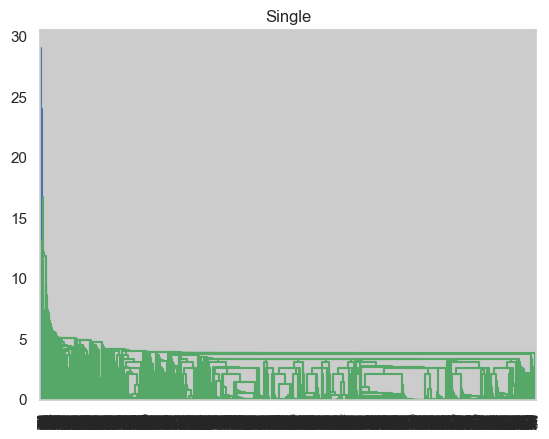

In [187]:
# метод "одиночной связи"
Y = linkage(X, 'single')
plt.title("Single")
dendrogram(Y)
plt.show()

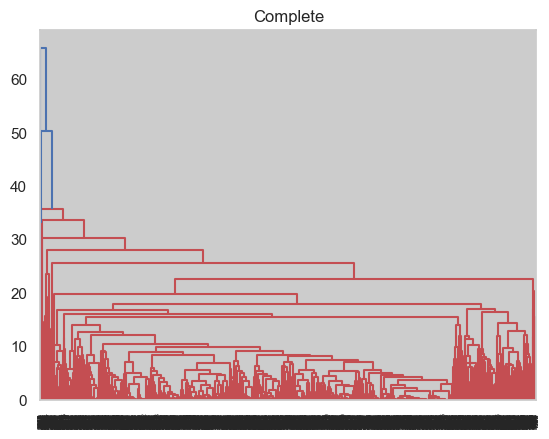

In [188]:
# метод "полной связи"
Y = linkage(X, 'complete')
plt.title("Complete")
dendrogram(Y)
plt.show()

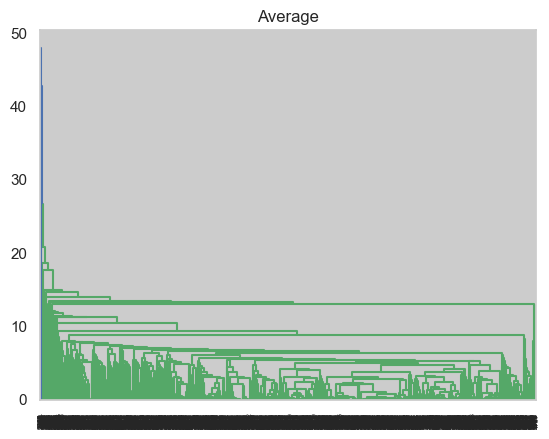

In [189]:
# метод "попарного среднего"
Y = linkage(X, 'average')
plt.title("Average")
dendrogram(Y)
plt.show()

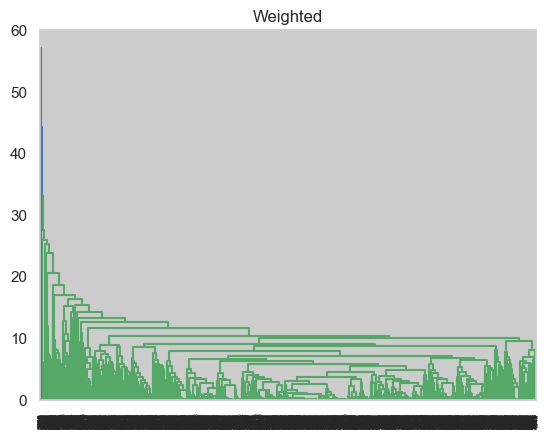

In [190]:
# метод "средне взвешенного"
Y = linkage(X, 'weighted')
plt.title("Weighted")
dendrogram(Y)
plt.show()

# MBA

In [566]:
df = df_clean.copy()
df = df.reset_index(drop=True)

In [567]:
df.head()

,Order_ID,Phone_new,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK
0,1303000520_TT,55575449-54535553535073,Онлайн-Резерв.,при получении,Центральный ф.о.,2420.0,1.0,0.0,2420.0,Аксессуары,Картриджи и бумага
1,1303000521_TT,55574954-53565052504871,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,8999.0,1.0,2000.0,8999.0,Крупная бытовая техника,Плиты
2,1303000523_TT,55575049-51505248534972,Онлайн-Резерв.,при получении,Центральный ф.о.,1790.0,1.0,0.0,1790.0,Цифровая Техника,Портативная электроника
3,1303000524_TT,55574954-53495654564877,Колл-центр,при получении,Северо-Западный ф.о.,1420.0,1.0,0.0,1420.0,Мелкая бытовая техника,Красота и здоровье
4,1303000525_TT,55575054-53544849485671,Онлайн-Резерв.,при получении,Центральный ф.о.,249.0,1.0,0.0,249.0,ТВ-Аудио,Музыкальные инструменты


In [568]:
df['TN_TK'] = df['TN'] + '_' + df['TK']

In [569]:
df.head()

,Order_ID,Phone_new,Source,PaymentType,Region,FullSum,Quant,RowDiscount,RowSum,TN,TK,TN_TK
0,1303000520_TT,55575449-54535553535073,Онлайн-Резерв.,при получении,Центральный ф.о.,2420.0,1.0,0.0,2420.0,Аксессуары,Картриджи и бумага,Аксессуары_Картриджи и бумага
1,1303000521_TT,55574954-53565052504871,Онлайн-Резерв.,при получении,Северо-Западный ф.о.,8999.0,1.0,2000.0,8999.0,Крупная бытовая техника,Плиты,Крупная бытовая техника_Плиты
2,1303000523_TT,55575049-51505248534972,Онлайн-Резерв.,при получении,Центральный ф.о.,1790.0,1.0,0.0,1790.0,Цифровая Техника,Портативная электроника,Цифровая Техника_Портативная электроника
3,1303000524_TT,55574954-53495654564877,Колл-центр,при получении,Северо-Западный ф.о.,1420.0,1.0,0.0,1420.0,Мелкая бытовая техника,Красота и здоровье,Мелкая бытовая техника_Красота и здоровье
4,1303000525_TT,55575054-53544849485671,Онлайн-Резерв.,при получении,Центральный ф.о.,249.0,1.0,0.0,249.0,ТВ-Аудио,Музыкальные инструменты,ТВ-Аудио_Музыкальные инструменты


In [570]:
df['TN_TK'].value_counts()

TN_TK
Мелкая бытовая техника_Приготовление пищи                13330
Крупная бытовая техника_Встраиваемая техника              6988
Крупная бытовая техника_Холодильное оборудование          5213
Цифровая Техника_Мобильные средства связи                 5036
Мелкая бытовая техника_Красота и здоровье                 5022
                                                         ...  
Аксессуары_Музыкальные инструменты                           1
ТВ-Аудио_Автомультимедия                                     1
Элитная техника_Встраиваемые микроволновые печи (VIP)        1
Мебель_Садовая мебель                                        1
ТВ-Аудио_Автоаудио                                           1
Name: count, Length: 104, dtype: int64

In [571]:
# create a dataframe to record customer information
data_mba = pd.DataFrame()
data_mba['id'] = df.drop_duplicates(subset = 'Phone_new')['Phone_new']
data_mba = data_mba.reset_index(drop=True)

In [572]:
data_mba.head()

,id
0,55575449-54535553535073
1,55574954-53565052504871
2,55575049-51505248534972
3,55574954-53495654564877
4,55575054-53544849485671


In [573]:
#column groupings
group_TN_TK = df.groupby(['Phone_new', 'TN_TK']).sum()

In [574]:
for i in df.TN_TK.unique():
    data_mba[i] = i
    data_mba = data_mba.merge(group_TN_TK['Quant'], left_on = ['id', i], right_on = ['Phone_new', 'TN_TK'], how = 'left')
    data_mba = data_mba.drop(columns = [i])
    data_mba = data_mba.rename(columns = {'Quant': i})
    data_mba = data_mba.fillna(0)

In [575]:
data_mba.head()

,id,Аксессуары_Картриджи и бумага,Крупная бытовая техника_Плиты,Цифровая Техника_Портативная электроника,Мелкая бытовая техника_Красота и здоровье,ТВ-Аудио_Музыкальные инструменты,Мелкая бытовая техника_Приготовление пищи,Аксессуары_Электропитание,Цифровая Техника_Мобильные средства связи,Мебель_Гостиная,Детские товары_Игрушки,Спорт и активный отдых_Велосипеды и аксессуары,Аксессуары_Аксессуары для комп./ноутбуков/принтеров,ТВ-Аудио_Автоэлектроника,Крупная бытовая техника_Стиральные машины,Крупная бытовая техника_Встраиваемая техника,Мелкая бытовая техника_Уход за домом,Сделай сам_Сантехника,Крупная бытовая техника_Холодильное оборудование,Аксессуары_Аксессуары для смартфонов и планшетов,Спорт и активный отдых_Фитнес,Сделай сам_Инструменты,Мебель_Прихожая,Климат_Вентиляторы бытовые,Климат_Увлажнители,"Игры, софт и развлечения_Игровые консоли",Товары для дома_Товары для кухни,Крупная бытовая техника_Посудомоечные машины,Детские товары_Прогулки и путешествие,Мебель_Аксессуары для мебели,Спорт и активный отдых_Тренажеры,Аксессуары_Аксессуары для бытовой техники,ТВ-Аудио_Телевизоры LCD,Аксессуары_Носители информации,Сделай сам_Силовая и садовая техника,Климат_Водонагреватели,Цифровая Техника_Планшеты,Спорт и активный отдых_Туризм,Спорт и активный отдых_Единоборства,Товары для дома_Хозтовары,Цифровая Техника_Периферийные устройства,Аксессуары_Сетевое оборудование,Аксессуары_Наушники,Детские товары_Детская комната,Цифровая Техника_Фотоаппараты,Мелкая бытовая техника_СВЧ,Мебель_Офис и Кабинет,Мебель_Спальня,Мелкая бытовая техника_Швейная техника,"Игры, софт и развлечения_Игры для консолей",Спорт и активный отдых_Тяжелая атлетика,Цифровая Техника_Средства связи,Детские товары_Кормление,Спорт и активный отдых_Зимние виды спорта,Аксессуары_Аксессуары ТВ-Аудио,Цифровая Техника_Компьютеры портативные,Товары для дома_Текстиль,ТВ-Аудио_Аудио-Видео,"Игры, софт и развлечения_Антивирусные программы",Мебель_Кухня и Столовая,Товары для дома_Свет,"Игры, софт и развлечения_Операционные системы",Климат_Очистители воздуха,Товары для дома_Декор интерьера,Спорт и активный отдых_Аксессуары для спортивных товаров,Аксессуары_Аксессуары для фото/видео,Детские товары_Для мам,ТВ-Аудио_Автомультимедия,Товары для дома_Сервировка стола,Климат_Воздухонагреватели,Сделай сам_Камины,Климат_Кондиционеры,Аксессуары_Освещение,Спорт и активный отдых_Активный отдых,Автотовары_Автопринадлежности,Цифровая Техника_Компьютеры настольные,ТВ-Аудио_Автомагнитолы,Спорт и активный отдых_Командные виды спорта,Мебель_Мягкая мебель,Детские товары_Купание и уход,ТВ-Аудио_Аксессуары авто,Детские товары_Аксессуары детство,ТВ-Аудио_Аудиомагнитолы,Спорт и активный отдых_Рыбалка,Цифровая Техника_Видеокамеры,Аксессуары_Умный дом,"Игры, софт и развлечения_DVD с записью",ТВ-Аудио_Навигация,ТВ-Аудио_Hi-Fi компоненты,ТВ-Аудио_Музыкальные центры,"Товары для дома_Ванна, баня и сауна",ТВ-Аудио_DVD/Blu-Ray плееры и компоненты,"Игры, софт и развлечения_Аксессуары для игровых приставок",ТВ-Аудио_Автоакустика,ТВ-Аудио_Домашние театры,Элитная техника_Встраиваемые духовые шкафы (VIP),Сделай сам_Товары для автолюбителей,Аксессуары_Музыкальные инструменты,Мебель_Ванная,Спорт и активный отдых_Индивидуальные виды спорта,Крупная бытовая техника_Сушильные машины,Элитная техника_Встраиваемые микроволновые печи (VIP),Мебель_Садовая мебель,Автотовары_Аккумуляторы,ТВ-Аудио_Автоаудио
0,55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [576]:
data_mba.shape

(88354, 105)

In [578]:
df_clusters = pd.read_excel('labels_for_12_clusters.xlsx')

In [579]:
df2 = df_clusters

In [580]:
df2

,id,Аксессуары,Крупная бытовая техника,Цифровая Техника,Мелкая бытовая техника,ТВ-Аудио,Мебель,Детские товары,Спорт и активный отдых,Сделай сам,Климат,"Игры, софт и развлечения",Товары для дома,Автотовары,Элитная техника,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Приволжский ф.о.,Уральский ф.о.,Южный ф.о.,Сибирский ф.о.,Дальневосточный ф.о.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,Labels
0,55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1.0,2420.0,1
1,55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,2000,1,1.0,8999.0,2
2,55575049-51505248534972,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1.0,1790.0,3
3,55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1.0,1420.0,0
4,55575054-53544849485671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1.0,249.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86582,55575054-49505554565675,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1.0,1390.0,0
86583,55575055-51565055494871,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1.0,19990.0,10
86584,55575053-55485548545470,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,500,1,1.0,11370.0,3
86585,55574957-51495048515075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1.0,899.0,3


In [581]:
#добавление столбца с номером кластера
data_mba['Cluster'] = None

In [582]:
#из таблицы сегментации заполняем столбец с номерами кластеров по ключу id
keys = ['id']
data_mba = data_mba.assign(Cluster=data_mba[keys].join(df2.drop_duplicates(keys).set_index(keys).Labels, on=keys).Labels)

In [583]:
data_mba.head()

,id,Аксессуары_Картриджи и бумага,Крупная бытовая техника_Плиты,Цифровая Техника_Портативная электроника,Мелкая бытовая техника_Красота и здоровье,ТВ-Аудио_Музыкальные инструменты,Мелкая бытовая техника_Приготовление пищи,Аксессуары_Электропитание,Цифровая Техника_Мобильные средства связи,Мебель_Гостиная,Детские товары_Игрушки,Спорт и активный отдых_Велосипеды и аксессуары,Аксессуары_Аксессуары для комп./ноутбуков/принтеров,ТВ-Аудио_Автоэлектроника,Крупная бытовая техника_Стиральные машины,Крупная бытовая техника_Встраиваемая техника,Мелкая бытовая техника_Уход за домом,Сделай сам_Сантехника,Крупная бытовая техника_Холодильное оборудование,Аксессуары_Аксессуары для смартфонов и планшетов,Спорт и активный отдых_Фитнес,Сделай сам_Инструменты,Мебель_Прихожая,Климат_Вентиляторы бытовые,Климат_Увлажнители,"Игры, софт и развлечения_Игровые консоли",Товары для дома_Товары для кухни,Крупная бытовая техника_Посудомоечные машины,Детские товары_Прогулки и путешествие,Мебель_Аксессуары для мебели,Спорт и активный отдых_Тренажеры,Аксессуары_Аксессуары для бытовой техники,ТВ-Аудио_Телевизоры LCD,Аксессуары_Носители информации,Сделай сам_Силовая и садовая техника,Климат_Водонагреватели,Цифровая Техника_Планшеты,Спорт и активный отдых_Туризм,Спорт и активный отдых_Единоборства,Товары для дома_Хозтовары,Цифровая Техника_Периферийные устройства,Аксессуары_Сетевое оборудование,Аксессуары_Наушники,Детские товары_Детская комната,Цифровая Техника_Фотоаппараты,Мелкая бытовая техника_СВЧ,Мебель_Офис и Кабинет,Мебель_Спальня,Мелкая бытовая техника_Швейная техника,"Игры, софт и развлечения_Игры для консолей",Спорт и активный отдых_Тяжелая атлетика,Цифровая Техника_Средства связи,Детские товары_Кормление,Спорт и активный отдых_Зимние виды спорта,Аксессуары_Аксессуары ТВ-Аудио,Цифровая Техника_Компьютеры портативные,Товары для дома_Текстиль,ТВ-Аудио_Аудио-Видео,"Игры, софт и развлечения_Антивирусные программы",Мебель_Кухня и Столовая,Товары для дома_Свет,"Игры, софт и развлечения_Операционные системы",Климат_Очистители воздуха,Товары для дома_Декор интерьера,Спорт и активный отдых_Аксессуары для спортивных товаров,Аксессуары_Аксессуары для фото/видео,Детские товары_Для мам,ТВ-Аудио_Автомультимедия,Товары для дома_Сервировка стола,Климат_Воздухонагреватели,Сделай сам_Камины,Климат_Кондиционеры,Аксессуары_Освещение,Спорт и активный отдых_Активный отдых,Автотовары_Автопринадлежности,Цифровая Техника_Компьютеры настольные,ТВ-Аудио_Автомагнитолы,Спорт и активный отдых_Командные виды спорта,Мебель_Мягкая мебель,Детские товары_Купание и уход,ТВ-Аудио_Аксессуары авто,Детские товары_Аксессуары детство,ТВ-Аудио_Аудиомагнитолы,Спорт и активный отдых_Рыбалка,Цифровая Техника_Видеокамеры,Аксессуары_Умный дом,"Игры, софт и развлечения_DVD с записью",ТВ-Аудио_Навигация,ТВ-Аудио_Hi-Fi компоненты,ТВ-Аудио_Музыкальные центры,"Товары для дома_Ванна, баня и сауна",ТВ-Аудио_DVD/Blu-Ray плееры и компоненты,"Игры, софт и развлечения_Аксессуары для игровых приставок",ТВ-Аудио_Автоакустика,ТВ-Аудио_Домашние театры,Элитная техника_Встраиваемые духовые шкафы (VIP),Сделай сам_Товары для автолюбителей,Аксессуары_Музыкальные инструменты,Мебель_Ванная,Спорт и активный отдых_Индивидуальные виды спорта,Крупная бытовая техника_Сушильные машины,Элитная техника_Встраиваемые микроволновые печи (VIP),Мебель_Садовая мебель,Автотовары_Аккумуляторы,ТВ-Аудио_Автоаудио,Cluster
0,55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [585]:
data_mba.to_csv('Data_for_MBA_all_clusters_true.csv')

**MBA analysis for cluster 0**

In [588]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [589]:
df = pd.read_csv('Data_for_MBA_all_clusters_true.csv')
df.set_index('id', inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [590]:
df.head()

,Аксессуары_Картриджи и бумага,Крупная бытовая техника_Плиты,Цифровая Техника_Портативная электроника,Мелкая бытовая техника_Красота и здоровье,ТВ-Аудио_Музыкальные инструменты,Мелкая бытовая техника_Приготовление пищи,Аксессуары_Электропитание,Цифровая Техника_Мобильные средства связи,Мебель_Гостиная,Детские товары_Игрушки,Спорт и активный отдых_Велосипеды и аксессуары,Аксессуары_Аксессуары для комп./ноутбуков/принтеров,ТВ-Аудио_Автоэлектроника,Крупная бытовая техника_Стиральные машины,Крупная бытовая техника_Встраиваемая техника,Мелкая бытовая техника_Уход за домом,Сделай сам_Сантехника,Крупная бытовая техника_Холодильное оборудование,Аксессуары_Аксессуары для смартфонов и планшетов,Спорт и активный отдых_Фитнес,Сделай сам_Инструменты,Мебель_Прихожая,Климат_Вентиляторы бытовые,Климат_Увлажнители,"Игры, софт и развлечения_Игровые консоли",Товары для дома_Товары для кухни,Крупная бытовая техника_Посудомоечные машины,Детские товары_Прогулки и путешествие,Мебель_Аксессуары для мебели,Спорт и активный отдых_Тренажеры,Аксессуары_Аксессуары для бытовой техники,ТВ-Аудио_Телевизоры LCD,Аксессуары_Носители информации,Сделай сам_Силовая и садовая техника,Климат_Водонагреватели,Цифровая Техника_Планшеты,Спорт и активный отдых_Туризм,Спорт и активный отдых_Единоборства,Товары для дома_Хозтовары,Цифровая Техника_Периферийные устройства,Аксессуары_Сетевое оборудование,Аксессуары_Наушники,Детские товары_Детская комната,Цифровая Техника_Фотоаппараты,Мелкая бытовая техника_СВЧ,Мебель_Офис и Кабинет,Мебель_Спальня,Мелкая бытовая техника_Швейная техника,"Игры, софт и развлечения_Игры для консолей",Спорт и активный отдых_Тяжелая атлетика,Цифровая Техника_Средства связи,Детские товары_Кормление,Спорт и активный отдых_Зимние виды спорта,Аксессуары_Аксессуары ТВ-Аудио,Цифровая Техника_Компьютеры портативные,Товары для дома_Текстиль,ТВ-Аудио_Аудио-Видео,"Игры, софт и развлечения_Антивирусные программы",Мебель_Кухня и Столовая,Товары для дома_Свет,"Игры, софт и развлечения_Операционные системы",Климат_Очистители воздуха,Товары для дома_Декор интерьера,Спорт и активный отдых_Аксессуары для спортивных товаров,Аксессуары_Аксессуары для фото/видео,Детские товары_Для мам,ТВ-Аудио_Автомультимедия,Товары для дома_Сервировка стола,Климат_Воздухонагреватели,Сделай сам_Камины,Климат_Кондиционеры,Аксессуары_Освещение,Спорт и активный отдых_Активный отдых,Автотовары_Автопринадлежности,Цифровая Техника_Компьютеры настольные,ТВ-Аудио_Автомагнитолы,Спорт и активный отдых_Командные виды спорта,Мебель_Мягкая мебель,Детские товары_Купание и уход,ТВ-Аудио_Аксессуары авто,Детские товары_Аксессуары детство,ТВ-Аудио_Аудиомагнитолы,Спорт и активный отдых_Рыбалка,Цифровая Техника_Видеокамеры,Аксессуары_Умный дом,"Игры, софт и развлечения_DVD с записью",ТВ-Аудио_Навигация,ТВ-Аудио_Hi-Fi компоненты,ТВ-Аудио_Музыкальные центры,"Товары для дома_Ванна, баня и сауна",ТВ-Аудио_DVD/Blu-Ray плееры и компоненты,"Игры, софт и развлечения_Аксессуары для игровых приставок",ТВ-Аудио_Автоакустика,ТВ-Аудио_Домашние театры,Элитная техника_Встраиваемые духовые шкафы (VIP),Сделай сам_Товары для автолюбителей,Аксессуары_Музыкальные инструменты,Мебель_Ванная,Спорт и активный отдых_Индивидуальные виды спорта,Крупная бытовая техника_Сушильные машины,Элитная техника_Встраиваемые микроволновые печи (VIP),Мебель_Садовая мебель,Автотовары_Аккумуляторы,ТВ-Аудио_Автоаудио,Cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55575449-54535553535073,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
55574954-53565052504871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [592]:
#данные по кластеру 0
df_0 = df.loc[df['Cluster'] == 0]

In [593]:
df_0.shape

(18487, 105)

In [594]:
MarkBas_0 = df_0.drop(columns='Cluster', axis=1)

In [595]:
MarkBas_0.head()

,Аксессуары_Картриджи и бумага,Крупная бытовая техника_Плиты,Цифровая Техника_Портативная электроника,Мелкая бытовая техника_Красота и здоровье,ТВ-Аудио_Музыкальные инструменты,Мелкая бытовая техника_Приготовление пищи,Аксессуары_Электропитание,Цифровая Техника_Мобильные средства связи,Мебель_Гостиная,Детские товары_Игрушки,Спорт и активный отдых_Велосипеды и аксессуары,Аксессуары_Аксессуары для комп./ноутбуков/принтеров,ТВ-Аудио_Автоэлектроника,Крупная бытовая техника_Стиральные машины,Крупная бытовая техника_Встраиваемая техника,Мелкая бытовая техника_Уход за домом,Сделай сам_Сантехника,Крупная бытовая техника_Холодильное оборудование,Аксессуары_Аксессуары для смартфонов и планшетов,Спорт и активный отдых_Фитнес,Сделай сам_Инструменты,Мебель_Прихожая,Климат_Вентиляторы бытовые,Климат_Увлажнители,"Игры, софт и развлечения_Игровые консоли",Товары для дома_Товары для кухни,Крупная бытовая техника_Посудомоечные машины,Детские товары_Прогулки и путешествие,Мебель_Аксессуары для мебели,Спорт и активный отдых_Тренажеры,Аксессуары_Аксессуары для бытовой техники,ТВ-Аудио_Телевизоры LCD,Аксессуары_Носители информации,Сделай сам_Силовая и садовая техника,Климат_Водонагреватели,Цифровая Техника_Планшеты,Спорт и активный отдых_Туризм,Спорт и активный отдых_Единоборства,Товары для дома_Хозтовары,Цифровая Техника_Периферийные устройства,Аксессуары_Сетевое оборудование,Аксессуары_Наушники,Детские товары_Детская комната,Цифровая Техника_Фотоаппараты,Мелкая бытовая техника_СВЧ,Мебель_Офис и Кабинет,Мебель_Спальня,Мелкая бытовая техника_Швейная техника,"Игры, софт и развлечения_Игры для консолей",Спорт и активный отдых_Тяжелая атлетика,Цифровая Техника_Средства связи,Детские товары_Кормление,Спорт и активный отдых_Зимние виды спорта,Аксессуары_Аксессуары ТВ-Аудио,Цифровая Техника_Компьютеры портативные,Товары для дома_Текстиль,ТВ-Аудио_Аудио-Видео,"Игры, софт и развлечения_Антивирусные программы",Мебель_Кухня и Столовая,Товары для дома_Свет,"Игры, софт и развлечения_Операционные системы",Климат_Очистители воздуха,Товары для дома_Декор интерьера,Спорт и активный отдых_Аксессуары для спортивных товаров,Аксессуары_Аксессуары для фото/видео,Детские товары_Для мам,ТВ-Аудио_Автомультимедия,Товары для дома_Сервировка стола,Климат_Воздухонагреватели,Сделай сам_Камины,Климат_Кондиционеры,Аксессуары_Освещение,Спорт и активный отдых_Активный отдых,Автотовары_Автопринадлежности,Цифровая Техника_Компьютеры настольные,ТВ-Аудио_Автомагнитолы,Спорт и активный отдых_Командные виды спорта,Мебель_Мягкая мебель,Детские товары_Купание и уход,ТВ-Аудио_Аксессуары авто,Детские товары_Аксессуары детство,ТВ-Аудио_Аудиомагнитолы,Спорт и активный отдых_Рыбалка,Цифровая Техника_Видеокамеры,Аксессуары_Умный дом,"Игры, софт и развлечения_DVD с записью",ТВ-Аудио_Навигация,ТВ-Аудио_Hi-Fi компоненты,ТВ-Аудио_Музыкальные центры,"Товары для дома_Ванна, баня и сауна",ТВ-Аудио_DVD/Blu-Ray плееры и компоненты,"Игры, софт и развлечения_Аксессуары для игровых приставок",ТВ-Аудио_Автоакустика,ТВ-Аудио_Домашние театры,Элитная техника_Встраиваемые духовые шкафы (VIP),Сделай сам_Товары для автолюбителей,Аксессуары_Музыкальные инструменты,Мебель_Ванная,Спорт и активный отдых_Индивидуальные виды спорта,Крупная бытовая техника_Сушильные машины,Элитная техника_Встраиваемые микроволновые печи (VIP),Мебель_Садовая мебель,Автотовары_Аккумуляторы,ТВ-Аудио_Автоаудио
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55574954-53495654564877,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55575050-49525049575475,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [596]:
#Create function to hot encode the values
def encode_values(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Apply function to data
basket_encoded_0 = MarkBas_0.applymap(encode_values)

basket_encoded_0.head()

/var/folders/m_/q7bdmmy93879kj5hcdgd5gsc0000gq/T/ipykernel_61612/1760409210.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded_0 = MarkBas_0.applymap(encode_values)


,Аксессуары_Картриджи и бумага,Крупная бытовая техника_Плиты,Цифровая Техника_Портативная электроника,Мелкая бытовая техника_Красота и здоровье,ТВ-Аудио_Музыкальные инструменты,Мелкая бытовая техника_Приготовление пищи,Аксессуары_Электропитание,Цифровая Техника_Мобильные средства связи,Мебель_Гостиная,Детские товары_Игрушки,Спорт и активный отдых_Велосипеды и аксессуары,Аксессуары_Аксессуары для комп./ноутбуков/принтеров,ТВ-Аудио_Автоэлектроника,Крупная бытовая техника_Стиральные машины,Крупная бытовая техника_Встраиваемая техника,Мелкая бытовая техника_Уход за домом,Сделай сам_Сантехника,Крупная бытовая техника_Холодильное оборудование,Аксессуары_Аксессуары для смартфонов и планшетов,Спорт и активный отдых_Фитнес,Сделай сам_Инструменты,Мебель_Прихожая,Климат_Вентиляторы бытовые,Климат_Увлажнители,"Игры, софт и развлечения_Игровые консоли",Товары для дома_Товары для кухни,Крупная бытовая техника_Посудомоечные машины,Детские товары_Прогулки и путешествие,Мебель_Аксессуары для мебели,Спорт и активный отдых_Тренажеры,Аксессуары_Аксессуары для бытовой техники,ТВ-Аудио_Телевизоры LCD,Аксессуары_Носители информации,Сделай сам_Силовая и садовая техника,Климат_Водонагреватели,Цифровая Техника_Планшеты,Спорт и активный отдых_Туризм,Спорт и активный отдых_Единоборства,Товары для дома_Хозтовары,Цифровая Техника_Периферийные устройства,Аксессуары_Сетевое оборудование,Аксессуары_Наушники,Детские товары_Детская комната,Цифровая Техника_Фотоаппараты,Мелкая бытовая техника_СВЧ,Мебель_Офис и Кабинет,Мебель_Спальня,Мелкая бытовая техника_Швейная техника,"Игры, софт и развлечения_Игры для консолей",Спорт и активный отдых_Тяжелая атлетика,Цифровая Техника_Средства связи,Детские товары_Кормление,Спорт и активный отдых_Зимние виды спорта,Аксессуары_Аксессуары ТВ-Аудио,Цифровая Техника_Компьютеры портативные,Товары для дома_Текстиль,ТВ-Аудио_Аудио-Видео,"Игры, софт и развлечения_Антивирусные программы",Мебель_Кухня и Столовая,Товары для дома_Свет,"Игры, софт и развлечения_Операционные системы",Климат_Очистители воздуха,Товары для дома_Декор интерьера,Спорт и активный отдых_Аксессуары для спортивных товаров,Аксессуары_Аксессуары для фото/видео,Детские товары_Для мам,ТВ-Аудио_Автомультимедия,Товары для дома_Сервировка стола,Климат_Воздухонагреватели,Сделай сам_Камины,Климат_Кондиционеры,Аксессуары_Освещение,Спорт и активный отдых_Активный отдых,Автотовары_Автопринадлежности,Цифровая Техника_Компьютеры настольные,ТВ-Аудио_Автомагнитолы,Спорт и активный отдых_Командные виды спорта,Мебель_Мягкая мебель,Детские товары_Купание и уход,ТВ-Аудио_Аксессуары авто,Детские товары_Аксессуары детство,ТВ-Аудио_Аудиомагнитолы,Спорт и активный отдых_Рыбалка,Цифровая Техника_Видеокамеры,Аксессуары_Умный дом,"Игры, софт и развлечения_DVD с записью",ТВ-Аудио_Навигация,ТВ-Аудио_Hi-Fi компоненты,ТВ-Аудио_Музыкальные центры,"Товары для дома_Ванна, баня и сауна",ТВ-Аудио_DVD/Blu-Ray плееры и компоненты,"Игры, софт и развлечения_Аксессуары для игровых приставок",ТВ-Аудио_Автоакустика,ТВ-Аудио_Домашние театры,Элитная техника_Встраиваемые духовые шкафы (VIP),Сделай сам_Товары для автолюбителей,Аксессуары_Музыкальные инструменты,Мебель_Ванная,Спорт и активный отдых_Индивидуальные виды спорта,Крупная бытовая техника_Сушильные машины,Элитная техника_Встраиваемые микроволновые печи (VIP),Мебель_Садовая мебель,Автотовары_Аккумуляторы,ТВ-Аудио_Автоаудио
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55574954-53495654564877,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55575050-49525049575475,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55575653-51564952554976,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [597]:
#filter for only invoices with 2 or more items
basket_filtered_0 = basket_encoded_0[(basket_encoded_0 > 0).sum(axis=1) >= 2]
basket_filtered_0.head()

,Аксессуары_Картриджи и бумага,Крупная бытовая техника_Плиты,Цифровая Техника_Портативная электроника,Мелкая бытовая техника_Красота и здоровье,ТВ-Аудио_Музыкальные инструменты,Мелкая бытовая техника_Приготовление пищи,Аксессуары_Электропитание,Цифровая Техника_Мобильные средства связи,Мебель_Гостиная,Детские товары_Игрушки,Спорт и активный отдых_Велосипеды и аксессуары,Аксессуары_Аксессуары для комп./ноутбуков/принтеров,ТВ-Аудио_Автоэлектроника,Крупная бытовая техника_Стиральные машины,Крупная бытовая техника_Встраиваемая техника,Мелкая бытовая техника_Уход за домом,Сделай сам_Сантехника,Крупная бытовая техника_Холодильное оборудование,Аксессуары_Аксессуары для смартфонов и планшетов,Спорт и активный отдых_Фитнес,Сделай сам_Инструменты,Мебель_Прихожая,Климат_Вентиляторы бытовые,Климат_Увлажнители,"Игры, софт и развлечения_Игровые консоли",Товары для дома_Товары для кухни,Крупная бытовая техника_Посудомоечные машины,Детские товары_Прогулки и путешествие,Мебель_Аксессуары для мебели,Спорт и активный отдых_Тренажеры,Аксессуары_Аксессуары для бытовой техники,ТВ-Аудио_Телевизоры LCD,Аксессуары_Носители информации,Сделай сам_Силовая и садовая техника,Климат_Водонагреватели,Цифровая Техника_Планшеты,Спорт и активный отдых_Туризм,Спорт и активный отдых_Единоборства,Товары для дома_Хозтовары,Цифровая Техника_Периферийные устройства,Аксессуары_Сетевое оборудование,Аксессуары_Наушники,Детские товары_Детская комната,Цифровая Техника_Фотоаппараты,Мелкая бытовая техника_СВЧ,Мебель_Офис и Кабинет,Мебель_Спальня,Мелкая бытовая техника_Швейная техника,"Игры, софт и развлечения_Игры для консолей",Спорт и активный отдых_Тяжелая атлетика,Цифровая Техника_Средства связи,Детские товары_Кормление,Спорт и активный отдых_Зимние виды спорта,Аксессуары_Аксессуары ТВ-Аудио,Цифровая Техника_Компьютеры портативные,Товары для дома_Текстиль,ТВ-Аудио_Аудио-Видео,"Игры, софт и развлечения_Антивирусные программы",Мебель_Кухня и Столовая,Товары для дома_Свет,"Игры, софт и развлечения_Операционные системы",Климат_Очистители воздуха,Товары для дома_Декор интерьера,Спорт и активный отдых_Аксессуары для спортивных товаров,Аксессуары_Аксессуары для фото/видео,Детские товары_Для мам,ТВ-Аудио_Автомультимедия,Товары для дома_Сервировка стола,Климат_Воздухонагреватели,Сделай сам_Камины,Климат_Кондиционеры,Аксессуары_Освещение,Спорт и активный отдых_Активный отдых,Автотовары_Автопринадлежности,Цифровая Техника_Компьютеры настольные,ТВ-Аудио_Автомагнитолы,Спорт и активный отдых_Командные виды спорта,Мебель_Мягкая мебель,Детские товары_Купание и уход,ТВ-Аудио_Аксессуары авто,Детские товары_Аксессуары детство,ТВ-Аудио_Аудиомагнитолы,Спорт и активный отдых_Рыбалка,Цифровая Техника_Видеокамеры,Аксессуары_Умный дом,"Игры, софт и развлечения_DVD с записью",ТВ-Аудио_Навигация,ТВ-Аудио_Hi-Fi компоненты,ТВ-Аудио_Музыкальные центры,"Товары для дома_Ванна, баня и сауна",ТВ-Аудио_DVD/Blu-Ray плееры и компоненты,"Игры, софт и развлечения_Аксессуары для игровых приставок",ТВ-Аудио_Автоакустика,ТВ-Аудио_Домашние театры,Элитная техника_Встраиваемые духовые шкафы (VIP),Сделай сам_Товары для автолюбителей,Аксессуары_Музыкальные инструменты,Мебель_Ванная,Спорт и активный отдых_Индивидуальные виды спорта,Крупная бытовая техника_Сушильные машины,Элитная техника_Встраиваемые микроволновые печи (VIP),Мебель_Садовая мебель,Автотовары_Аккумуляторы,ТВ-Аудио_Автоаудио
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55575056-49535549545171,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55574954-54565349525277,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55574954-51505154535270,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [598]:
basket_filtered_0.shape

(285, 104)

In [599]:
basket_filtered_0.to_csv('mba_1.csv')

In [600]:
#Generate the frequent itemsets
frequent_itemsets_0 = apriori(basket_filtered_0, min_support=0.03, use_colnames=True).sort_values("support",ascending=False)
frequent_itemsets_0.head(10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
1,0.771930,(Мелкая бытовая техника_Приготовление пищи)
0,0.452632,(Мелкая бытовая техника_Красота и здоровье)
2,0.449123,(Мелкая бытовая техника_Уход за домом)
5,0.312281,"(Мелкая бытовая техника_Приготовление пищи, Ме..."
7,0.266667,"(Мелкая бытовая техника_Приготовление пищи, Ме..."
3,0.207018,(Мелкая бытовая техника_СВЧ)
8,0.133333,"(Мелкая бытовая техника_Приготовление пищи, Ме..."
6,0.098246,"(Мелкая бытовая техника_Красота и здоровье, Ме..."
4,0.066667,(Мелкая бытовая техника_Швейная техника)
9,0.049123,"(Мелкая бытовая техника_Уход за домом, Мелкая ..."


In [602]:
#Apply association rules
assoc_rules_0 = association_rules(frequent_itemsets_0, metric="lift", min_threshold=0.2).sort_values("lift",ascending=False).reset_index(drop=True)
assoc_rules_0.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_Красота и здоровье),0.771930,0.452632,0.312281,0.404545,0.893763,1.0,-0.037119,0.919245,-0.342614,0.342308,-0.087850,0.547234
1,(Мелкая бытовая техника_Красота и здоровье),(Мелкая бытовая техника_Приготовление пищи),0.452632,0.771930,0.312281,0.689922,0.893763,1.0,-0.037119,0.735526,-0.178413,0.342308,-0.359571,0.547234
2,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_СВЧ),0.771930,0.207018,0.133333,0.172727,0.834361,1.0,-0.026470,0.958550,-0.465368,0.157676,-0.043242,0.408398
3,(Мелкая бытовая техника_СВЧ),(Мелкая бытовая техника_Приготовление пищи),0.207018,0.771930,0.133333,0.644068,0.834361,1.0,-0.026470,0.640769,-0.200224,0.157676,-0.560626,0.408398
4,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_Уход за домом),0.771930,0.449123,0.266667,0.345455,0.769176,1.0,-0.080025,0.841618,-0.568182,0.279412,-0.188188,0.469602


**MBA analysis for cluster 1**

In [604]:
df = pd.read_csv('Data_for_MBA_all_clusters_true.csv')
df.set_index('id', inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [605]:
#данные по кластеру 1
df_1 = df.loc[df['Cluster'] == 1]

In [607]:
MarkBas_1 = df_0.drop(columns='Cluster', axis=1)

In [608]:
#Create function to hot encode the values
def encode_values(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Apply function to data
basket_encoded_1 = MarkBas_1.applymap(encode_values)

#basket_encoded_1.head()

/var/folders/m_/q7bdmmy93879kj5hcdgd5gsc0000gq/T/ipykernel_61612/1350698065.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded_1 = MarkBas_1.applymap(encode_values)


In [609]:
#filter for only invoices with 2 or more items
basket_filtered_1 = basket_encoded_1[(basket_encoded_1 > 0).sum(axis=1) >= 2]
#basket_filtered_1.head()

In [610]:
basket_filtered_1.shape

(285, 104)

In [612]:
basket_filtered_1.to_csv('mba_2.csv')

In [613]:
#Generate the frequent itemsets
frequent_itemsets_1 = apriori(basket_filtered_1, min_support=0.03, use_colnames=True).sort_values("support",ascending=False)
frequent_itemsets_1.head(10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
1,0.771930,(Мелкая бытовая техника_Приготовление пищи)
0,0.452632,(Мелкая бытовая техника_Красота и здоровье)
2,0.449123,(Мелкая бытовая техника_Уход за домом)
5,0.312281,"(Мелкая бытовая техника_Приготовление пищи, Ме..."
7,0.266667,"(Мелкая бытовая техника_Приготовление пищи, Ме..."
3,0.207018,(Мелкая бытовая техника_СВЧ)
8,0.133333,"(Мелкая бытовая техника_Приготовление пищи, Ме..."
6,0.098246,"(Мелкая бытовая техника_Красота и здоровье, Ме..."
4,0.066667,(Мелкая бытовая техника_Швейная техника)
9,0.049123,"(Мелкая бытовая техника_Уход за домом, Мелкая ..."


In [614]:
#Apply association rules
assoc_rules_1 = association_rules(frequent_itemsets_1, metric="lift", min_threshold=0.2).sort_values("lift",ascending=False).reset_index(drop=True)
assoc_rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_Красота и здоровье),0.771930,0.452632,0.312281,0.404545,0.893763,1.0,-0.037119,0.919245,-0.342614,0.342308,-0.087850,0.547234
1,(Мелкая бытовая техника_Красота и здоровье),(Мелкая бытовая техника_Приготовление пищи),0.452632,0.771930,0.312281,0.689922,0.893763,1.0,-0.037119,0.735526,-0.178413,0.342308,-0.359571,0.547234
2,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_СВЧ),0.771930,0.207018,0.133333,0.172727,0.834361,1.0,-0.026470,0.958550,-0.465368,0.157676,-0.043242,0.408398
3,(Мелкая бытовая техника_СВЧ),(Мелкая бытовая техника_Приготовление пищи),0.207018,0.771930,0.133333,0.644068,0.834361,1.0,-0.026470,0.640769,-0.200224,0.157676,-0.560626,0.408398
4,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_Уход за домом),0.771930,0.449123,0.266667,0.345455,0.769176,1.0,-0.080025,0.841618,-0.568182,0.279412,-0.188188,0.469602
5,(Мелкая бытовая техника_Уход за домом),(Мелкая бытовая техника_Приготовление пищи),0.449123,0.771930,0.266667,0.593750,0.769176,1.0,-0.080025,0.561404,-0.352648,0.279412,-0.781250,0.469602
6,(Мелкая бытовая техника_Уход за домом),(Мелкая бытовая техника_СВЧ),0.449123,0.207018,0.049123,0.109375,0.528337,1.0,-0.043853,0.890366,-0.618403,0.080925,-0.123133,0.173332
7,(Мелкая бытовая техника_СВЧ),(Мелкая бытовая техника_Уход за домом),0.207018,0.449123,0.049123,0.237288,0.528337,1.0,-0.043853,0.722261,-0.529587,0.080925,-0.384541,0.173332
8,(Мелкая бытовая техника_Красота и здоровье),(Мелкая бытовая техника_Уход за домом),0.452632,0.449123,0.098246,0.217054,0.483285,1.0,-0.105042,0.703596,-0.661395,0.122271,-0.421271,0.217902
9,(Мелкая бытовая техника_Уход за домом),(Мелкая бытовая техника_Красота и здоровье),0.449123,0.452632,0.098246,0.218750,0.483285,1.0,-0.105042,0.700632,-0.659963,0.122271,-0.427284,0.217902


In [615]:
assoc_rules_1.to_excel('Associacions_for_cluster_1.xlsx')

**Анализ MBA для кластера 2**

In [619]:
df = pd.read_csv('Data_for_MBA_all_clusters_true.csv')
df.set_index('id', inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [621]:
#данные по кластеру 2
df_2 = df.loc[df['Cluster'] == 2]

In [622]:
MarkBas_2 = df_0.drop(columns='Cluster', axis=1)

In [623]:
#Create function to hot encode the values
def encode_values(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Apply function to data
basket_encoded_1 = MarkBas_2.applymap(encode_values)

#basket_encoded_1.head()

/var/folders/m_/q7bdmmy93879kj5hcdgd5gsc0000gq/T/ipykernel_61612/1857562862.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded_1 = MarkBas_2.applymap(encode_values)


In [626]:
#filter for only invoices with 2 or more items
basket_filtered_2 = basket_encoded_1[(basket_encoded_1 > 0).sum(axis=1) >= 2]
#basket_filtered_1.head()

In [627]:
basket_filtered_2.shape

(285, 104)

In [628]:
basket_filtered_2.to_csv('mba_3.csv')

In [629]:
#Generate the frequent itemsets
frequent_itemsets_2 = apriori(basket_filtered_2, min_support=0.03, use_colnames=True).sort_values("support",ascending=False)
frequent_itemsets_2.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
1,0.771930,(Мелкая бытовая техника_Приготовление пищи)
0,0.452632,(Мелкая бытовая техника_Красота и здоровье)
2,0.449123,(Мелкая бытовая техника_Уход за домом)
5,0.312281,"(Мелкая бытовая техника_Приготовление пищи, Ме..."
7,0.266667,"(Мелкая бытовая техника_Приготовление пищи, Ме..."


In [630]:
#Apply association rules
assoc_rules_2 = association_rules(frequent_itemsets_2, metric="lift", min_threshold=0.2).sort_values("lift",ascending=False).reset_index(drop=True)
assoc_rules_2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_Красота и здоровье),0.771930,0.452632,0.312281,0.404545,0.893763,1.0,-0.037119,0.919245,-0.342614,0.342308,-0.087850,0.547234
1,(Мелкая бытовая техника_Красота и здоровье),(Мелкая бытовая техника_Приготовление пищи),0.452632,0.771930,0.312281,0.689922,0.893763,1.0,-0.037119,0.735526,-0.178413,0.342308,-0.359571,0.547234
2,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_СВЧ),0.771930,0.207018,0.133333,0.172727,0.834361,1.0,-0.026470,0.958550,-0.465368,0.157676,-0.043242,0.408398
3,(Мелкая бытовая техника_СВЧ),(Мелкая бытовая техника_Приготовление пищи),0.207018,0.771930,0.133333,0.644068,0.834361,1.0,-0.026470,0.640769,-0.200224,0.157676,-0.560626,0.408398
4,(Мелкая бытовая техника_Приготовление пищи),(Мелкая бытовая техника_Уход за домом),0.771930,0.449123,0.266667,0.345455,0.769176,1.0,-0.080025,0.841618,-0.568182,0.279412,-0.188188,0.469602
